# Assignment 3

### Group 3

- #### Yang Li:  Converting yearly data to monthly data, AWS, web applications with Streamlit- 
- #### Xinyu Cao: Collect Data, Simple models to predict rent, video editting
- #### Samantha Quilat: Data Wrangling, Feature Engineering, Modelling (XGBoost, LightGBM, and CatBoost), Forecasting (Predicting future values for 'Median Rent' and 'Total Sentences' for the years 2025-2034 using the trained models), Selecting the best model based on the lowest MSE for each region and target variable ('Median Rent' and 'Total Sentences'), Visualization, Exporting the predictions and best models' results to CSV files
- #### Tamsin Rodgers: collecting data, rent and crime predictions by location, leading comunication

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.arima.model import ARIMA
from scipy.interpolate import CubicSpline



# 1. Prepare Data

#### Dataset Sources:
- Rental Data: https://www.tenancy.govt.nz/about-tenancy-services/data-and-statistics/rental-bond-data/
- Crime Data: https://explore.data.stats.govt.nz/vis?pg=0&snb=20&tm=crime&vw=tb&df[ds]=ds-nsiws-disseminate&df[id]=JUS_CAL_001&df[ag]=STATSNZ&df[vs]=1.0&dq=.00.T.T.T.16%2B23%2B29%2B100%2B200%2BT.&ly[rw]=YEAR_JUS_CAL_001&ly[cl]=COURT_CLUSTER_JUS_CAL_001%2CSENTENCE_JUS_CAL_001&to[TIME]=false 

### 1.1 Combined yearly data

#### 1.1.1 Rent Data

In [4]:
rental_data = pd.read_csv('Detailed-Monthly-September-2024-Rental-bond-data-Regional.csv')

# Convert 'Time Frame' to datetime and extract the year
rental_data['Time Frame'] = pd.to_datetime(rental_data['Time Frame'], format='%Y-%d-%m')
rental_data['Year'] = rental_data['Time Frame'].dt.year

# Convert numeric columns
numeric_columns = rental_data.select_dtypes(include=['float64', 'int64']).columns
rental_data[numeric_columns] = rental_data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Group rental data by 'Year', 'Location Id', and 'Location'
rental_grouped = rental_data.groupby(['Year', 'Location Id', 'Location']).mean(numeric_only=True).reset_index()

# Drop the unwanted column
rental_grouped = rental_grouped.drop(columns=['Location Id'])

rental_grouped.rename(columns={'Location': 'Region'}, inplace=True)
rental_grouped.drop(columns=['Active Bonds'], inplace=True)

rental_grouped

,Year,Region,Median Rent,Geometric Mean Rent,Upper Quartile Rent,Lower Quartile Rent,Log Std Dev Weekly Rent
0,1993,ALL,151.363636,152.272727,189.090909,120.909091,0.383636
1,1993,Northland Region,124.090909,120.636364,145.363636,103.636364,0.285455
2,1993,Auckland Region,184.090909,189.000000,229.545455,152.727273,0.350909
3,1993,Waikato Region,130.000000,129.636364,162.272727,106.818182,0.320000
4,1993,Bay of Plenty Region,142.272727,136.636364,161.363636,119.090909,0.279091
...,...,...,...,...,...,...,...
539,2024,Otago Region,567.857143,534.714286,747.142857,394.000000,0.511429
540,2024,Southland Region,452.857143,414.285714,505.714286,373.428571,0.337143
541,2024,Tasman Region,573.285714,538.714286,651.285714,472.142857,0.277143
542,2024,Nelson Region,540.714286,502.428571,624.857143,443.714286,0.332857


#### 1.1.2 Crime Data 

In [5]:
crime_data = pd.read_csv('TotalSentences_per_Region_Crime_Data.csv')

crime_data

,Year,Location,Total Sentences
0,1981,Total Regions,125574
1,1981,Te Tai Tokerau Justice Service Area,3977
2,1981,Auckland Justice Service Area,14318
3,1981,South Auckland Justice Service Area,12388
4,1981,Waikato Justice Service Area,7199
...,...,...,...
699,2024,Wellington Justice Service Area,1017
700,2024,Nelson/Marlborough/West Coast Justice Service ...,2036
701,2024,Canterbury Justice Service Area,4694
702,2024,Otago Justice Service Area,1925


#### 1.1.3 Combined Data

##### Justice Service Areas in Each Region:
1. ALL - Total Region
2. Northland Region - Te Tai Tokerau Justice Service Area
3. Auckland Region - Auckland Justice Service Area, South Auckland Justice Service Area, Waitematā Justice Service Area
4. Waikato Region - Waikato Justice Service Area
5. Bay of Plenty Region - Bay of Plenty Justice Service Area, Waiariki Justice Service Area
6. Gisborne Region  - East Coast Justice Service Area
7. Hawke's Bay Region - (No specific justice service area listed; consider it as part of East Coast)
8. Taranaki Region - Taranaki/Whanganui Justice Service Area
9. Manawatu-Wanganui Region - Manawatū/Wairarapa Justice Service Area
10. Wellington Region - Northern Wellington Justice Service Area, Wellington Justice Service Area
11. West Coast Region - Nelson/Marlborough/West Coast Justice Service Area
12. Canterbury Region - Canterbury Justice Service Area
13. Otago Region - Otago Justice Service Area
14. Southland Region - Southland Justice Service Area
15. Tasman Region - Nelson/Marlborough/West Coast Justice Service Area
16. Nelson Region - Nelson/Marlborough/West Coast Justice Service Area
17. Marlborough Region - Nelson/Marlborough/West Coast Justice Service Area

##### Final features for the Dataset
- Year
- Region
- Median Rent
- Geometric Mean Rent
- Upper Quartile Rent
- Lower Quartile Rent
- Log Std Dev Weekly Rent
- Total Sentences - (Total Crime Rate: Imprisonment Sentences, Community Sentences, Monetary, Others, No sentence recorded)

In [6]:
merged_data = pd.merge(rental_grouped, crime_data, on=['Year'], how='inner')
merged_data

,Year,Region,Median Rent,Geometric Mean Rent,Upper Quartile Rent,Lower Quartile Rent,Log Std Dev Weekly Rent,Location,Total Sentences
0,1993,ALL,151.363636,152.272727,189.090909,120.909091,0.383636,Total Regions,78679
1,1993,ALL,151.363636,152.272727,189.090909,120.909091,0.383636,Te Tai Tokerau Justice Service Area,2684
2,1993,ALL,151.363636,152.272727,189.090909,120.909091,0.383636,Auckland Justice Service Area,8914
3,1993,ALL,151.363636,152.272727,189.090909,120.909091,0.383636,South Auckland Justice Service Area,7834
4,1993,ALL,151.363636,152.272727,189.090909,120.909091,0.383636,Waikato Justice Service Area,6205
...,...,...,...,...,...,...,...,...,...
8699,2024,Marlborough Region,545.428571,490.571429,635.142857,433.285714,0.440000,Wellington Justice Service Area,1017
8700,2024,Marlborough Region,545.428571,490.571429,635.142857,433.285714,0.440000,Nelson/Marlborough/West Coast Justice Service ...,2036
8701,2024,Marlborough Region,545.428571,490.571429,635.142857,433.285714,0.440000,Canterbury Justice Service Area,4694
8702,2024,Marlborough Region,545.428571,490.571429,635.142857,433.285714,0.440000,Otago Justice Service Area,1925


In [7]:
# Create a mapping of Justice Service Areas to their corresponding Regions
region_mapping = {
    'Total Regions': 'ALL',
    'Te Tai Tokerau Justice Service Area': 'Northland Region',
    'Auckland Justice Service Area': 'Auckland Region',
    'South Auckland Justice Service Area': 'Auckland Region',
    'Waikato Justice Service Area': 'Waikato Region',
    'Bay of Plenty Justice Service Area': 'Bay of Plenty Region',
    'Waiariki Justice Service Area': 'Bay of Plenty Region',
    'East Coast Justice Service Area': 'Gisborne Region',
    'Taranaki/Whanganui Justice Service Area': 'Taranaki Region',
    'Manawatū/Wairarapa Justice Service Area': 'Manawatu-Wanganui Region',
    'Northern Wellington Justice Service Area': 'Wellington Region',
    'Wellington Justice Service Area': 'Wellington Region',
    'Nelson/Marlborough/West Coast Justice Service Area': 'West Coast Region',
    'Canterbury Justice Service Area': 'Canterbury Region',
    'Otago Justice Service Area': 'Otago Region',
    'Southland Justice Service Area': 'Southland Region',
    'Nelson/Marlborough/West Coast Justice Service Area': 'Tasman Region',
    'Nelson/Marlborough/West Coast Justice Service Area': 'Nelson Region',
    'Nelson/Marlborough/West Coast Justice Service Area': 'Marlborough Region'
}

# Map the Locations to Regions
merged_data['Region'] = merged_data['Location'].map(region_mapping)

# Group by Year and Region, calculating the mean for the relevant columns
grouped_data = merged_data.groupby(['Year', 'Region']).mean(numeric_only=True).reset_index()

grouped_data

,Year,Region,Median Rent,Geometric Mean Rent,Upper Quartile Rent,Lower Quartile Rent,Log Std Dev Weekly Rent,Total Sentences
0,1993,ALL,138.967914,136.069519,166.042781,115.074866,0.311497,78679.0
1,1993,Auckland Region,138.967914,136.069519,166.042781,115.074866,0.311497,8374.0
2,1993,Bay of Plenty Region,138.967914,136.069519,166.042781,115.074866,0.311497,4522.5
3,1993,Canterbury Region,138.967914,136.069519,166.042781,115.074866,0.311497,8032.0
4,1993,Gisborne Region,138.967914,136.069519,166.042781,115.074866,0.311497,5444.0
...,...,...,...,...,...,...,...,...
411,2024,Otago Region,563.109244,528.495798,660.529412,454.991597,0.362269,1925.0
412,2024,Southland Region,563.109244,528.495798,660.529412,454.991597,0.362269,1617.0
413,2024,Taranaki Region,563.109244,528.495798,660.529412,454.991597,0.362269,2369.0
414,2024,Waikato Region,563.109244,528.495798,660.529412,454.991597,0.362269,3973.0


In [8]:
grouped_data.to_csv('grouped_data.csv', index=False)

### 1.2 Combined monthly data

#### 1.2.1 Rent Data

The rent dataset is handled and Median Rent is selected as the dependent variable.

In [9]:
rent = pd.read_csv('Detailed-Monthly-September-2024-Rental-bond-data-Regional.csv')
rent['Time Frame'] = pd.to_datetime(rent['Time Frame'])
rent = rent[['Time Frame','Location Id','Location','Median Rent']]
rent = rent[(rent['Location Id'] != -99) & (rent['Location Id'] != -1) ]
rent['Location'] = rent['Location'].str.split(' Region').str[0]
rent['Location'] = rent['Location'].replace('Manawatu-Wanganui', 'Manawatu-Whanganui')

Read in gdp data and handle it. Since Tasman/Nelson is treated as one place in this dataset, make two copies of it and divide it into Tasman and Nelson.

#### 1.2.2 Crime Data

In [10]:
crime = pd.read_csv('TotalSentences_per_Region_Crime_Data.csv')

In [11]:
crime = crime[crime['Location'] != "Total Regions"]
crime['Location'] = crime['Location'].apply(lambda x: x.replace(' Justice Service Area', ''))
crime.rename(columns={'Total Sentences': 'Crime'}, inplace=True)

Both Auckland and Wellington are split into two regions, so I used averages to merge them.

In [12]:
auckland_rows = crime[crime['Location'].isin(['Auckland', 'South Auckland'])]
auckland_mean = auckland_rows.groupby('Year').agg({'Crime': 'mean'}).reset_index()
auckland_mean['Location'] = 'Auckland'
crime = crime[(crime['Location'] != "Auckland") & (crime['Location'] != "South Auckland")]
crime = pd.concat([crime, auckland_mean], ignore_index=True).sort_values(by='Year')

In [13]:
wellington_rows = crime[crime['Location'].isin(['Wellington', 'Northern Wellington'])]
wellington_mean = wellington_rows.groupby('Year').agg({'Crime': 'mean'}).reset_index()
wellington_mean['Location'] = 'Wellington'
crime = crime[(crime['Location'] != "Wellington") & (crime['Location'] != "Northern Wellington")]
crime = pd.concat([crime, wellington_mean], ignore_index=True).sort_values(by='Year')

In [14]:
area_mapping = {
    'Te Tai Tokerau': 'Northland',
    'East Coast': 'Gisborne',
    'Taranaki/Whanganui': 'Taranaki',
    'Manawatū/Wairarapa': 'Manawatu-Whanganui',
}
crime['Location'] = crime['Location'].replace(area_mapping)

In [15]:
west_coast_nelson_rows = crime[crime['Location'] == 'Nelson/Marlborough/West Coast']
west_coast_rows = west_coast_nelson_rows.copy()
west_coast_rows['Location'] = 'West Coast'

nelson_rows = west_coast_nelson_rows.copy()
nelson_rows['Location'] = 'Nelson'
crime = crime[crime['Location'] != 'Nelson/Marlborough/West Coast'].append([west_coast_rows, nelson_rows], ignore_index=True).sort_values(by='Year')

C:\Users\HP\AppData\Local\Temp\ipykernel_19568\2821217298.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  crime = crime[crime['Location'] != 'Nelson/Marlborough/West Coast'].append([west_coast_rows, nelson_rows], ignore_index=True).sort_values(by='Year')


In [16]:
rent['Year'] = rent['Time Frame'].dt.year
rent_yearly = rent.groupby(['Year','Location', 'Location Id']).agg({'Median Rent': 'mean'}).reset_index()

In [17]:
rent_crime_yearly = pd.merge(rent_yearly, crime, left_on=['Year', 'Location'], right_on=['Year', 'Location'], how='inner')

The current crime data is yearly, using CubicSpline to make them monthly.

In [18]:
crime['Date'] = pd.to_datetime(crime['Year'], format='%Y') + pd.offsets.YearBegin(0)
crime.set_index('Date', inplace=True)
crime_monthly = pd.DataFrame()

for location in crime['Location'].unique():
    crime_location = crime[crime['Location'] == location]

    years = crime_location.index.year
    crime_values = crime_location['Crime']

    months = pd.date_range(start=str(years.min()), end=str(years.max() + 1), freq='MS')

    spline = CubicSpline(years, crime_values)
    interpolated_crime = spline(months.year + months.month / 12)

    interpolated_data = pd.DataFrame({
        'Date': months,
        'Location': location,
        'Crime': interpolated_crime
    })

    crime_monthly = pd.concat([crime_monthly, interpolated_data])

crime_monthly.reset_index(drop=True, inplace=True)

Inspection of the Auckland data shows that the interpolation is working well.

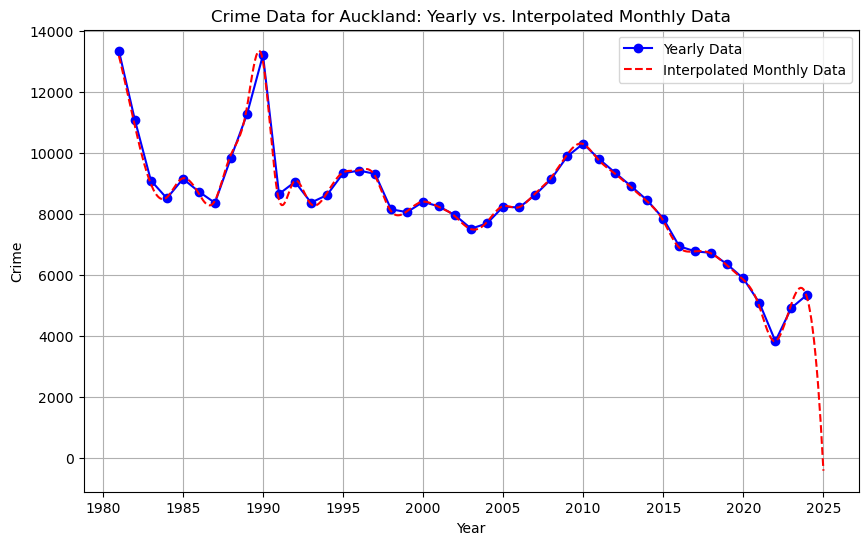

In [19]:
crime_auckland = crime[crime['Location'] == 'Auckland']
crime_monthly_auckland = crime_monthly[crime_monthly['Location'] == 'Auckland']

plt.figure(figsize=(10, 6))
plt.plot(crime_auckland.index, crime_auckland['Crime'], label='Yearly Data', marker='o', linestyle='-', color='b')
plt.plot(crime_monthly_auckland['Date'], crime_monthly_auckland['Crime'], label='Interpolated Monthly Data', linestyle='--', color='r')

plt.xlabel('Year')
plt.ylabel('Crime')
plt.title('Crime Data for Auckland: Yearly vs. Interpolated Monthly Data')
plt.legend()


plt.grid(True)
plt.show()

Save monthly crime data.

In [20]:
crime_monthly.to_csv('G:/course/20242/297301/assignment3/crime_monthly.csv', index=False)

#### 1.2.3 Combined Data

##### Final features for the Dataset
- Year
- Location Id	
- Median Rent
- Location
- Crime

In [22]:
rent_crime_monthly = pd.merge(rent, crime_monthly, left_on=['Time Frame', 'Location'], right_on=['Date', 'Location'], how='inner').drop(columns=['Date','Year'])

In [24]:
rent_crime_monthly.head(5)

,Time Frame,Location Id,Location,Median Rent,Crime
0,1993-02-01,1,Northland,120,2653.310946
1,1993-02-01,2,Auckland,180,8294.479729
2,1993-02-01,3,Waikato,120,6268.876663
3,1993-02-01,4,Bay of Plenty,140,4449.023224
4,1993-02-01,5,Gisborne,120,5473.953628


Save both yearly and monthly data.

In [25]:
rent_crime_monthly.to_csv('rent_crime_monthly.csv', index=False)
rent_crime_yearly.to_csv('rent_crime_yearly.csv', index=False)

## 2. Prediction of Future Rent and Crime Rate

Dataset:
- grouped_data

Feature Selection: 
- Year
- Region

The target variables can be each of the rental-related metrics:
- Median Rent
- Total Sentences

### 2.1 Predicted Future Rent in regards to Year, Region, and Total Sentences

In [26]:
target_columns = ['Median Rent', 'Total Sentences']
regions = grouped_data['Region'].unique()

predictions_list = []
best_model_results = []

for region in regions:
    
    # Median Rent
    rental_region_data = rental_grouped[rental_grouped['Region'] == region]
    
    # Features (X) and targets (y) for Median Rent
    X_rental = rental_region_data.drop(columns=['Year', 'Region'] + [col for col in target_columns if col in rental_region_data.columns])
    y_rental = rental_region_data['Median Rent']

    X_train_rental, X_test_rental, y_train_rental, y_test_rental = train_test_split(X_rental, y_rental, test_size=0.2, random_state=42)

    # Total Sentences
    sentences_region_data = grouped_data[grouped_data['Region'] == region]

    # Features (X) and targets (y) for Total Sentences
    X_sentences = sentences_region_data.drop(columns=['Year', 'Region'] + [col for col in target_columns if col in sentences_region_data.columns])
    y_sentences = sentences_region_data['Total Sentences']

    X_train_sentences, X_test_sentences, y_train_sentences, y_test_sentences = train_test_split(X_sentences, y_sentences, test_size=0.2, random_state=42)

    # Future feature values for the next years
    years = np.arange(2025, 2035)
    future_X = []
    for year in years:
        future_features = X_rental.mean().values * (1 + (year - 2025) * 0.02)  
        future_X.append(future_features)

    future_X = np.array(future_X)
    future_X = pd.DataFrame(future_X, columns=X_train_rental.columns)

    mse_results_rental = {}

    # XGBoost for Median Rent
    xgb_model_rental = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb_model_rental.fit(X_train_rental, y_train_rental)
    y_pred_xgb_rental = xgb_model_rental.predict(future_X)
    mse_xgb_rental = mean_squared_error(y_test_rental, xgb_model_rental.predict(X_test_rental))
    mse_results_rental['XGBoost'] = mse_xgb_rental

    for year, prediction in zip(years, y_pred_xgb_rental):
        predictions_list.append({
            'Year': year,
            'Region': region,
            'Target': 'Median Rent',
            'Model': 'XGBoost',
            'MSE': mse_xgb_rental,
            'Predicted': prediction
        })

    # LightGBM for Median Rent
    lgb_model_rental = lgb.LGBMRegressor(
        objective='regression', 
        num_leaves=100,      
        max_depth=-10,       
        learning_rate=0.1,   
        min_data_in_leaf=5, 
        random_state=42
    )
    lgb_model_rental.fit(X_train_rental, y_train_rental)
    y_pred_lgb_rental = lgb_model_rental.predict(future_X)
    mse_lgb_rental = mean_squared_error(y_test_rental, lgb_model_rental.predict(X_test_rental))
    mse_results_rental['LightGBM'] = mse_lgb_rental

    for year, prediction in zip(years, y_pred_lgb_rental):
        predictions_list.append({
            'Year': year,
            'Region': region,
            'Target': 'Median Rent',
            'Model': 'LightGBM',
            'MSE': mse_lgb_rental,
            'Predicted': prediction
        })

    # CatBoost for Median Rent
    cat_model_rental = CatBoostRegressor(verbose=0, random_seed=42)
    cat_model_rental.fit(X_train_rental, y_train_rental)
    y_pred_cat_rental = cat_model_rental.predict(future_X)
    mse_cat_rental = mean_squared_error(y_test_rental, cat_model_rental.predict(X_test_rental))
    mse_results_rental['CatBoost'] = mse_cat_rental

    for year, prediction in zip(years, y_pred_cat_rental):
        predictions_list.append({
            'Year': year,
            'Region': region,
            'Target': 'Median Rent',
            'Model': 'CatBoost',
            'MSE': mse_cat_rental,
            'Predicted': prediction
        })

    # Find the best model for Median Rent based on MSE
    best_model_name_rental = min(mse_results_rental, key=mse_results_rental.get)
    best_model_mse_rental = mse_results_rental[best_model_name_rental]
    best_model_results.append({
        'Region': region,
        'Target': 'Median Rent',
        'Best Model': best_model_name_rental,
        'MSE': best_model_mse_rental
    })

    mse_results_sentences = {}

    # XGBoost for Total Sentences
    xgb_model_sentences = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb_model_sentences.fit(X_train_sentences, y_train_sentences)
    y_pred_xgb_sentences = xgb_model_sentences.predict(future_X)
    mse_xgb_sentences = mean_squared_error(y_test_sentences, xgb_model_sentences.predict(X_test_sentences))
    mse_results_sentences['XGBoost'] = mse_xgb_sentences

    for year, prediction in zip(years, y_pred_xgb_sentences):
        predictions_list.append({
            'Year': year,
            'Region': region,
            'Target': 'Total Sentences',
            'Model': 'XGBoost',
            'MSE': mse_xgb_sentences,
            'Predicted': prediction
        })
  
    # LightGBM for Total Sentences
    lgb_model_sentences = lgb.LGBMRegressor(
        objective='regression', 
        num_leaves=100,      
        max_depth=-10,       
        learning_rate=0.1,   
        min_data_in_leaf=5, 
        random_state=42
    )
    lgb_model_sentences.fit(X_train_sentences, y_train_sentences)
    y_pred_lgb_sentences = lgb_model_sentences.predict(future_X)
    mse_lgb_sentences = mean_squared_error(y_test_sentences, lgb_model_sentences.predict(X_test_sentences))
    mse_results_sentences['LightGBM'] = mse_lgb_sentences

    for year, prediction in zip(years, y_pred_lgb_sentences):
        predictions_list.append({
            'Year': year,
            'Region': region,
            'Target': 'Total Sentences',
            'Model': 'LightGBM',
            'MSE': mse_lgb_sentences,
            'Predicted': prediction
        })

    # CatBoost for Total Sentences
    cat_model_sentences = CatBoostRegressor(verbose=0, random_seed=42)
    cat_model_sentences.fit(X_train_sentences, y_train_sentences)
    y_pred_cat_sentences = cat_model_sentences.predict(future_X)
    mse_cat_sentences = mean_squared_error(y_test_sentences, cat_model_sentences.predict(X_test_sentences))
    mse_results_sentences['CatBoost'] = mse_cat_sentences

    for year, prediction in zip(years, y_pred_cat_sentences):
        predictions_list.append({
            'Year': year,
            'Region': region,
            'Target': 'Total Sentences',
            'Model': 'CatBoost',
            'MSE': mse_cat_sentences,
            'Predicted': prediction
        })

    # Find the best model for Total Sentences based on MSE
    best_model_name_sentences = min(mse_results_sentences, key=mse_results_sentences.get)
    best_model_mse_sentences = mse_results_sentences[best_model_name_sentences]
    best_model_results.append({
        'Region': region,
        'Target': 'Total Sentences',
        'Best Model': best_model_name_sentences,
        'MSE': best_model_mse_sentences
    })

predictions = pd.DataFrame(predictions_list)
best_models_df = pd.DataFrame(best_model_results)

predictions

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 38
[LightGBM] [Info] Number of data points in the train set: 25, number of used features: 4
[LightGBM] [Info] Start training from score 302.688352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

,Year,Region,Target,Model,MSE,Predicted
0,2025,ALL,Median Rent,XGBoost,959.701955,297.917572
1,2026,ALL,Median Rent,XGBoost,959.701955,312.763641
2,2027,ALL,Median Rent,XGBoost,959.701955,323.911102
3,2028,ALL,Median Rent,XGBoost,959.701955,323.928986
4,2029,ALL,Median Rent,XGBoost,959.701955,339.739441
...,...,...,...,...,...,...
775,2030,Wellington Region,Total Sentences,CatBoost,84369.870036,2210.870710
776,2031,Wellington Region,Total Sentences,CatBoost,84369.870036,2174.440923
777,2032,Wellington Region,Total Sentences,CatBoost,84369.870036,2174.440923
778,2033,Wellington Region,Total Sentences,CatBoost,84369.870036,2118.826197


In [27]:
best_models_df

,Region,Target,Best Model,MSE
0,ALL,Median Rent,CatBoost,2.450291e+02
1,ALL,Total Sentences,CatBoost,1.924457e+07
2,Auckland Region,Median Rent,CatBoost,2.080181e+02
3,Auckland Region,Total Sentences,XGBoost,4.513987e+05
4,Bay of Plenty Region,Median Rent,CatBoost,8.450351e+02
5,Bay of Plenty Region,Total Sentences,XGBoost,1.291984e+05
6,Canterbury Region,Median Rent,CatBoost,3.005098e+02
7,Canterbury Region,Total Sentences,CatBoost,1.184185e+05
8,Gisborne Region,Median Rent,CatBoost,2.433888e+02
9,Gisborne Region,Total Sentences,CatBoost,8.254360e+04


In [28]:
predictions.to_csv('predictions.csv', index=False)

### 2.2 Visualization plot for predicted median rent (which includes total sentences or crime into account) and Total Sentences 

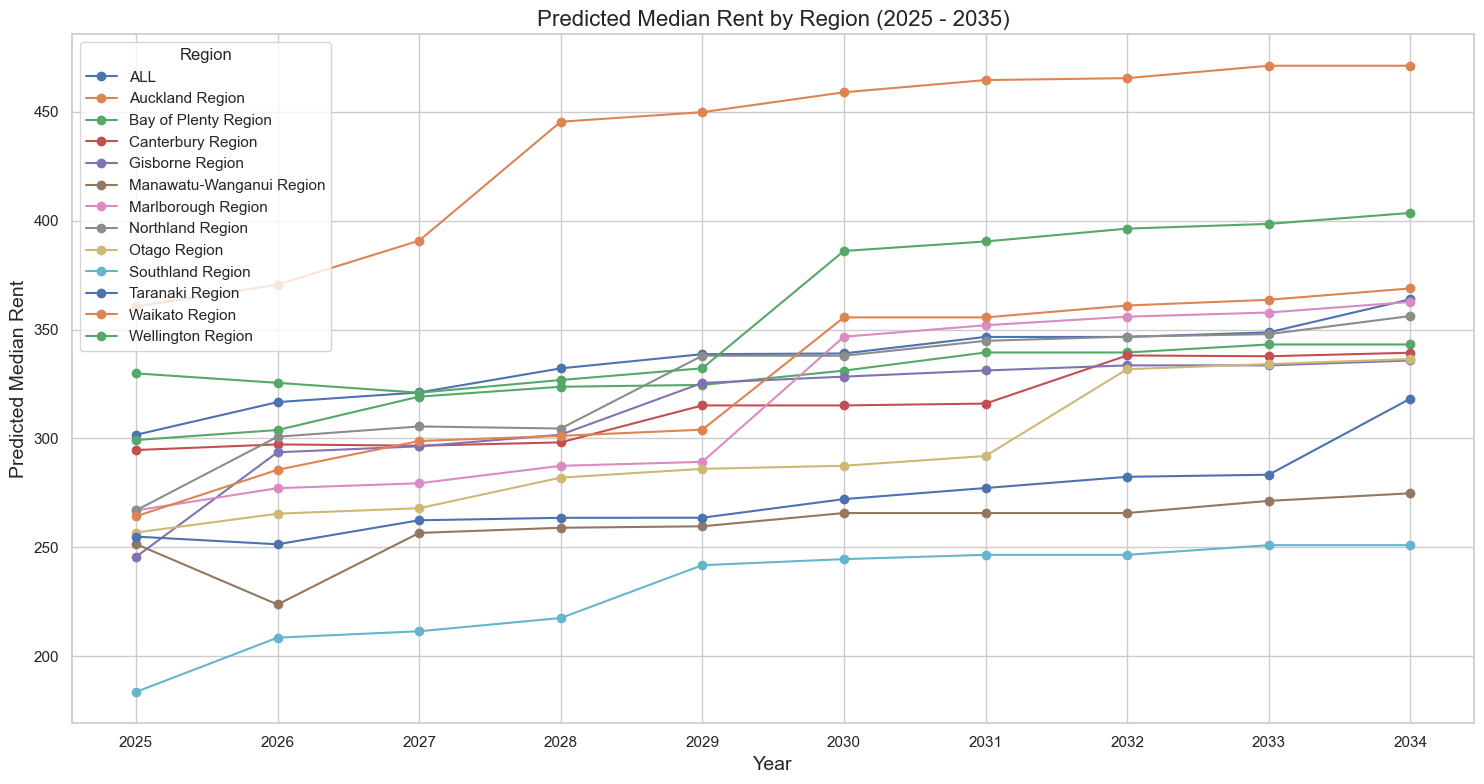

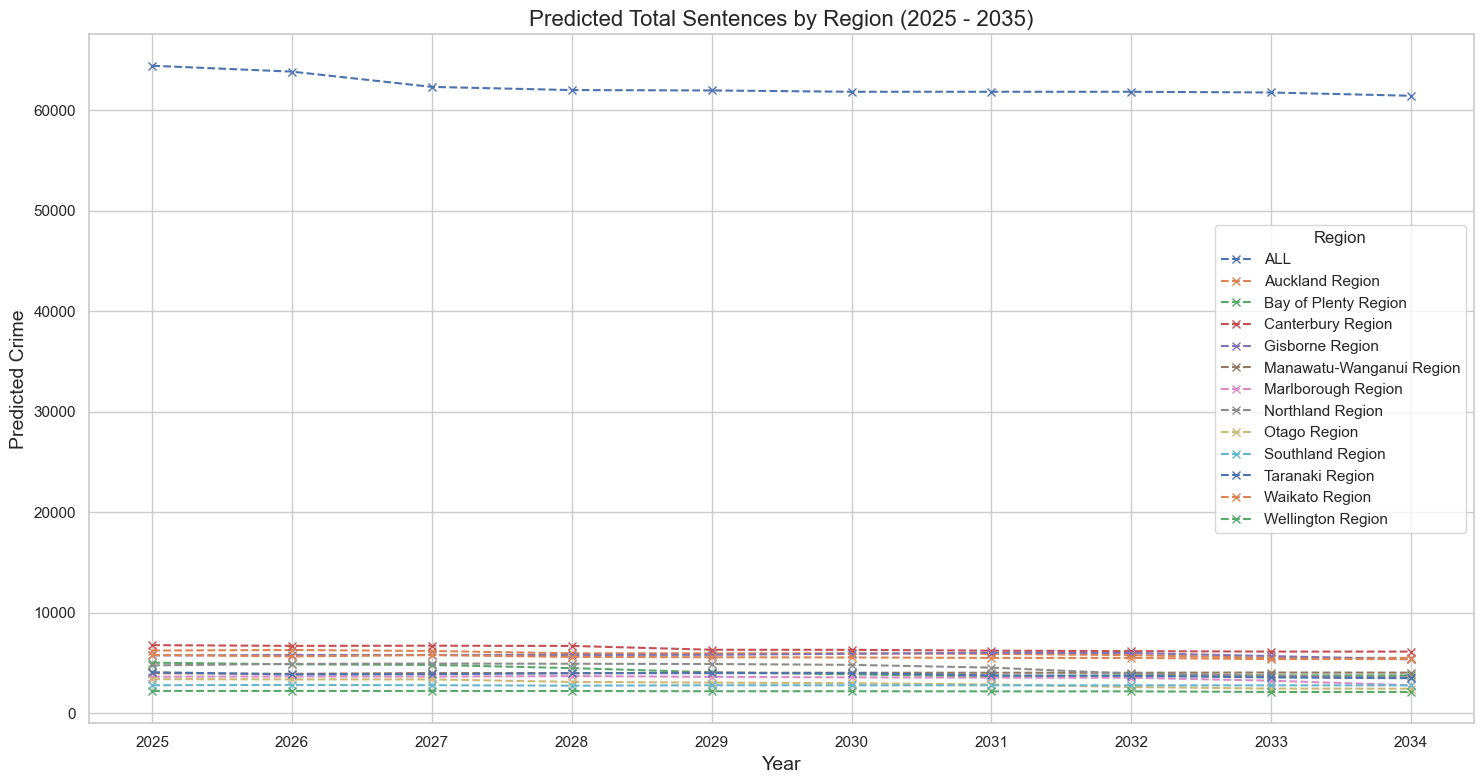

In [29]:
predictions['Predicted'] = pd.to_numeric(predictions['Predicted'], errors='coerce')

# Drop rows with NaN in 'Predicted'
predictions = predictions.dropna(subset=['Predicted'])

# Filter for 'Median Rent' and group by Year and Region
median_rent_predictions = predictions[predictions['Target'] == 'Median Rent']
median_rent_predictions = median_rent_predictions.groupby(['Year', 'Region'], as_index=False).mean(numeric_only=True)

total_sentences_predictions = predictions[predictions['Target'] == 'Total Sentences'].groupby(['Year', 'Region'], as_index=False).mean(numeric_only=True)

sns.set(style="whitegrid")

# Figure for Predicted Median Rent
plt.figure(figsize=(15, 8))
for region in median_rent_predictions['Region'].unique():
    region_data = median_rent_predictions[median_rent_predictions['Region'] == region]
    plt.plot(region_data['Year'], region_data['Predicted'], marker='o', label=region)

# Titles and labels for Median Rent
plt.title('Predicted Median Rent by Region (2025 - 2035)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Predicted Median Rent', fontsize=14)
plt.xticks(median_rent_predictions['Year'].unique())
plt.legend(title='Region')
plt.grid(True)

plt.tight_layout()
plt.show()

# Figure for Predicted Total Sentences
plt.figure(figsize=(15, 8))
for region in total_sentences_predictions['Region'].unique():
    region_data = total_sentences_predictions[total_sentences_predictions['Region'] == region]
    plt.plot(region_data['Year'], region_data['Predicted'], marker='x', linestyle='--', label=region)

# Titles and labels for Total Sentences
plt.title('Predicted Total Sentences by Region (2025 - 2035)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Predicted Crime', fontsize=14)
plt.xticks(total_sentences_predictions['Year'].unique())
plt.legend(title='Region')
plt.grid(True)

plt.tight_layout()
plt.show()

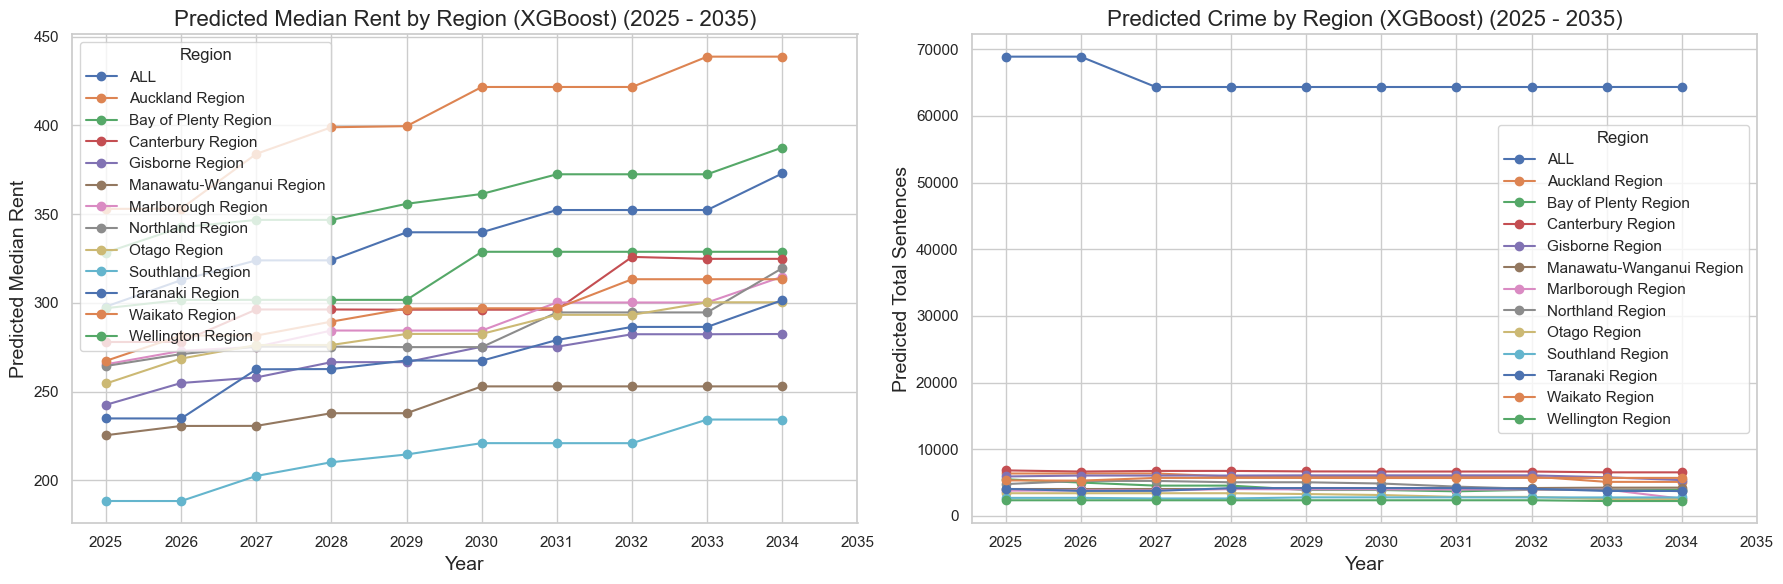

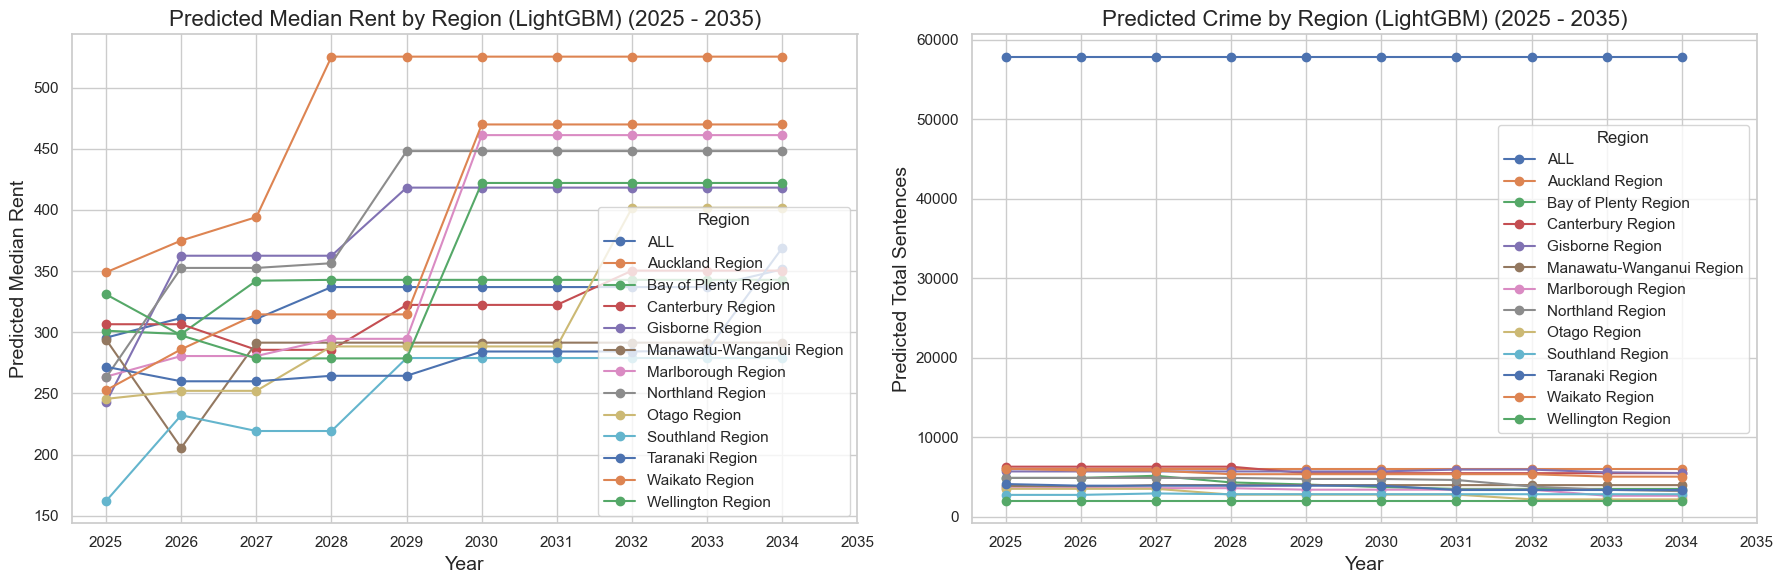

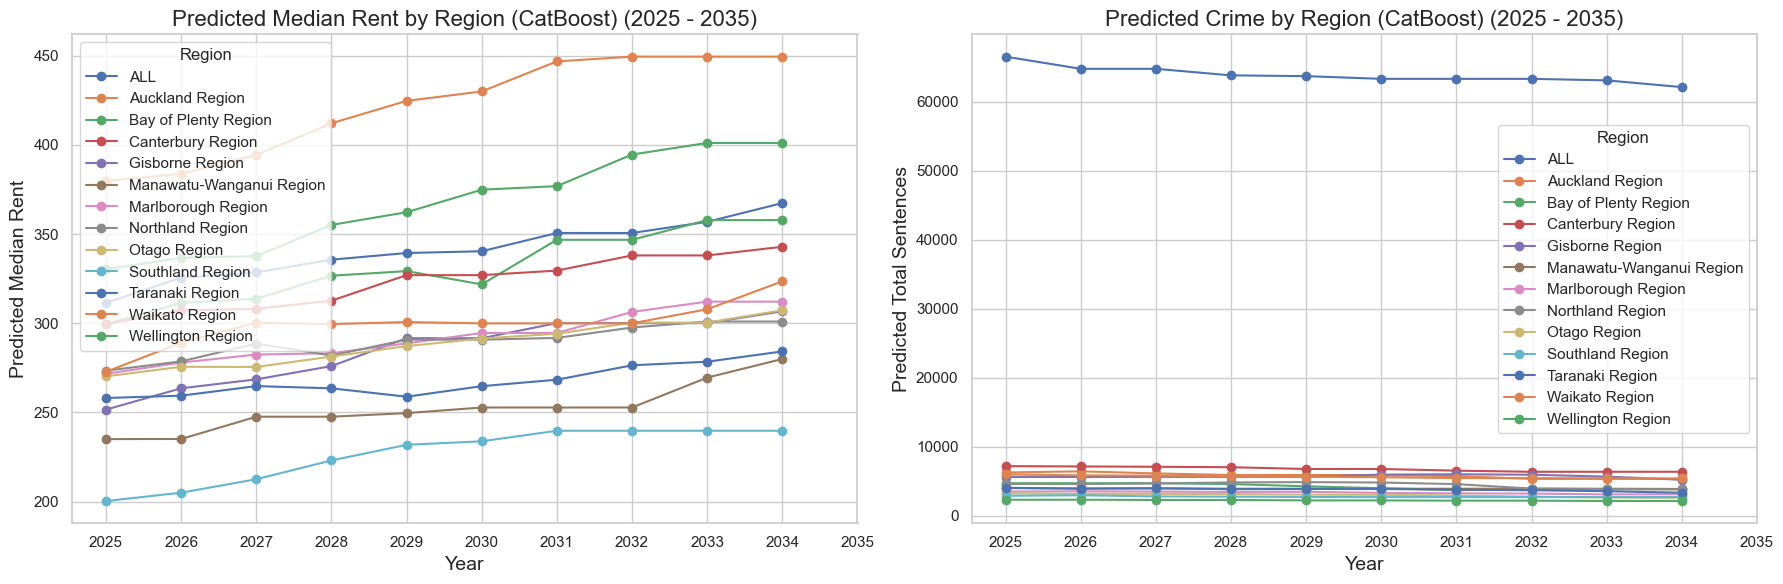

In [30]:
sns.set(style="whitegrid")

# Function to plot predictions for a specific model and target
def plot_model_predictions_for_each_target(predictions, model_name):
    # Filter predictions for the specific model
    model_predictions = predictions[predictions['Model'] == model_name]
    
    # Create a figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot Median Rent
    median_rent_data = model_predictions[model_predictions['Target'] == 'Median Rent']
    for region in median_rent_data['Region'].unique():
        region_data = median_rent_data[median_rent_data['Region'] == region]
        axes[0].plot(region_data['Year'], region_data['Predicted'], marker='o', label=region)

    # Adding titles and labels for Median Rent
    axes[0].set_title(f'Predicted Median Rent by Region ({model_name}) (2025 - 2035)', fontsize=16)
    axes[0].set_xlabel('Year', fontsize=14)
    axes[0].set_ylabel('Predicted Median Rent', fontsize=14)
    axes[0].set_xticks(np.arange(2025, 2036))  # Ensure all years are shown
    axes[0].legend(title='Region')
    axes[0].grid(True)

    # Plot Total Sentences
    total_sentences_data = model_predictions[model_predictions['Target'] == 'Total Sentences']
    for region in total_sentences_data['Region'].unique():
        region_data = total_sentences_data[total_sentences_data['Region'] == region]
        axes[1].plot(region_data['Year'], region_data['Predicted'], marker='o', label=region)

    # Adding titles and labels for Total Sentences
    axes[1].set_title(f'Predicted Crime by Region ({model_name}) (2025 - 2035)', fontsize=16)
    axes[1].set_xlabel('Year', fontsize=14)
    axes[1].set_ylabel('Predicted Total Sentences', fontsize=14)
    axes[1].set_xticks(np.arange(2025, 2036))  # Ensure all years are shown
    axes[1].legend(title='Region')
    axes[1].grid(True)

    # Show the plots for the model
    plt.tight_layout()
    plt.show()

# Plot for each model
for model in ['XGBoost', 'LightGBM', 'CatBoost']:
    plot_model_predictions_for_each_target(predictions, model)

## 3. Simple models to predict Rent

Dataset:
- rent_crime_monthly

Feature Selection: 
- Time Frame
- Location Id	
- Location
- Crime

The target variables can be each of the rental-related metrics:
- Median Rent

### 3.1 linear regression

Mean Squared Error (MSE) on test set: 3784922.4367936132


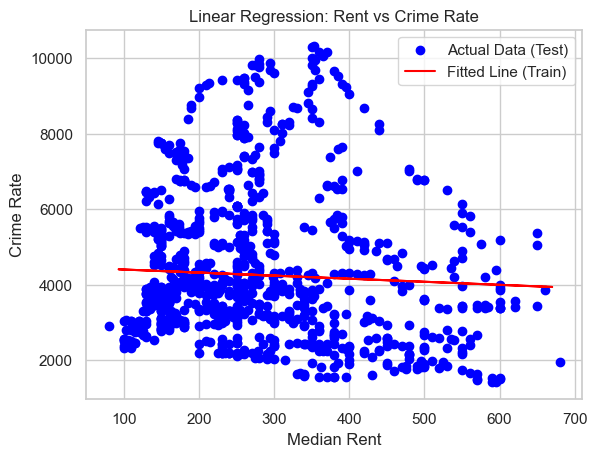

In [32]:
# Select feature and target 
X = rent_crime_monthly[['Median Rent']]
Y = rent_crime_monthly['Crime']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, Y_train)

# Make predictions
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# Calculate the MSE
mse = mean_squared_error(Y_test, Y_test_pred)
print(f"Mean Squared Error (MSE) on test set: {mse}")

# Plot the test data
plt.scatter(X_test, Y_test, color='blue', label='Actual Data (Test)')
plt.plot(X_train, Y_train_pred, color='red', label='Fitted Line (Train)')
plt.xlabel('Median Rent')
plt.ylabel('Crime Rate')
plt.title('Linear Regression: Rent vs Crime Rate')
plt.legend()
plt.show()


from the graph, the linear regression model is very mediocre in capturing the trend of the data, fitting a flatter straight line

### 3.2 Polynomial Regression

Polynomial Regression MSE: 3591895.114379794


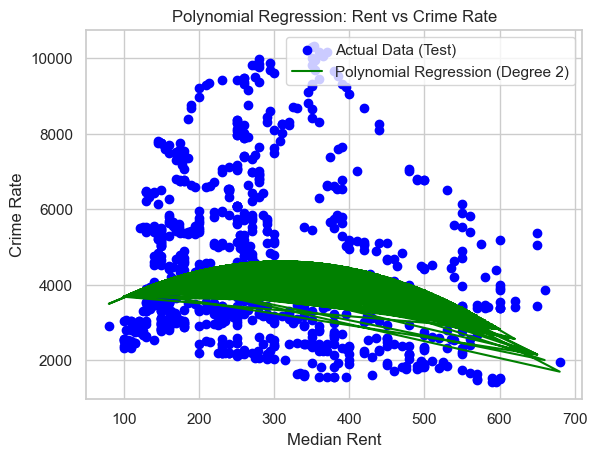

In [33]:
# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train a linear regression model with polynomial features
model_poly = LinearRegression()
model_poly.fit(X_train_poly, Y_train)

# Make predictions and calculate MSE
Y_test_pred_poly = model_poly.predict(X_test_poly)
mse_poly = mean_squared_error(Y_test, Y_test_pred_poly)
print(f"Polynomial Regression MSE: {mse_poly}")

plt.scatter(X_test, Y_test, color='blue', label='Actual Data (Test)')
plt.plot(X_test, Y_test_pred_poly, color='green', label='Polynomial Regression (Degree 2)')
plt.xlabel('Median Rent')
plt.ylabel('Crime Rate')
plt.title('Polynomial Regression: Rent vs Crime Rate')
plt.legend()
plt.show()


The polynomial regression fitted data lines showed overfitting, the fitted curves were complex and did not capture the trend of the actual data very well

### 3.3 Random Forest Regression

Random Forest Regression MSE: 3445444.1046841065


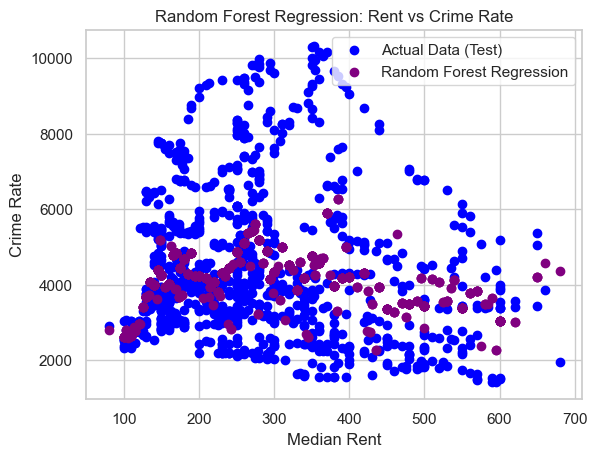

In [34]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, Y_train)

Y_test_pred_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error(Y_test, Y_test_pred_rf)
print(f"Random Forest Regression MSE: {mse_rf}")

#plot
plt.scatter(X_test, Y_test, color='blue', label='Actual Data (Test)')
plt.scatter(X_test, Y_test_pred_rf, color='purple', label='Random Forest Regression')
plt.xlabel('Median Rent')
plt.ylabel('Crime Rate')
plt.title('Random Forest Regression: Rent vs Crime Rate')
plt.legend()
plt.show()


The data fitted by the curvilinear tree is relatively stable and reduces the possibility of overfitting

## 4. Rent Forecasting and Visualization with ARIMA

Dataset:
- rent_crime_monthly

Feature Selection: 
- Time Frame	
- Location

The target variables can be each of the rental-related metrics:
- Median Rent

### 4.1 Quarterly Rent Forecast with ARIMA

In [35]:
df = pd.read_csv('rent_crime_monthly.csv')
df['Time Frame'] = pd.to_datetime(df['Time Frame'])
le_location = LabelEncoder()
df['Location'] = le_location.fit_transform(df['Location'])

N = 3  # Number of past values to include
m = 4  # Forecasting horizon (quarters)
predictions = {}

for loc in le_location.classes_:
    loc_encoded = le_location.transform([loc])[0]
    loc_data = df[df['Location'] == loc_encoded].set_index('Time Frame').resample('Q').mean()['Median Rent']
    loc_df = pd.DataFrame(loc_data) 
    for i in range(1, N + 1):
        loc_df[f'lag_{i}'] = loc_data.shift(i)
    loc_df.dropna(inplace=True)
    X = loc_df.drop('Median Rent', axis=1)
    y = loc_df['Median Rent']

    model = ARIMA(y, order=(1, 1, 1)) 
    model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=m)
    predicted_rent = forecast.predicted_mean

    predictions[loc] = predicted_rent

print("Predicted quarterly rents for each location for the next year:\n")
for loc, rents in predictions.items():
    print(f'Location: {loc}\n')
    for quarter in range(m):
        forecast_date = pd.date_range(start=loc_data.index[-1] + pd.DateOffset(months=(quarter + 1) * 3), periods=1)[0]
        quarter_number = (forecast_date.month - 1) // 3 + 1
        print(f"{forecast_date.year}-Q{quarter_number} : {rents[quarter]:.2f}")
    
    print("\n" + "="*40 + "\n")


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\HP\anaconda3\lib\site-packages\st

Predicted quarterly rents for each location for the next year:

Location: Auckland

2024-Q4 : 654.60
2025-Q1 : 659.20
2025-Q2 : 663.78
2025-Q3 : 668.36


Location: Bay of Plenty

2024-Q4 : 658.67
2025-Q1 : 667.30
2025-Q2 : 675.90
2025-Q3 : 684.46


Location: Canterbury

2024-Q4 : 539.77
2025-Q1 : 539.81
2025-Q2 : 539.80
2025-Q3 : 539.80


Location: Gisborne

2024-Q4 : 581.51
2025-Q1 : 580.95
2025-Q2 : 581.15
2025-Q3 : 581.08


Location: Manawatu-Whanganui

2024-Q4 : 526.94
2025-Q1 : 520.03
2025-Q2 : 526.91
2025-Q3 : 520.06


Location: Nelson

2024-Q4 : 539.64
2025-Q1 : 539.72
2025-Q2 : 539.70
2025-Q3 : 539.71


Location: Northland

2024-Q4 : 565.92
2025-Q1 : 571.80
2025-Q2 : 577.65
2025-Q3 : 583.46


Location: Otago

2024-Q4 : 551.98
2025-Q1 : 552.37
2025-Q2 : 552.45
2025-Q3 : 552.46


Location: Southland

2024-Q4 : 466.73
2025-Q1 : 473.42
2025-Q2 : 480.09
2025-Q3 : 486.71


Location: Taranaki

2024-Q4 : 567.86
2025-Q1 : 575.63
2025-Q2 : 583.32
2025-Q3 : 590.92


Location: Waikato

202

### 4.2 Forecasting Rent for 2030 and 2035

In [36]:
df = pd.read_csv('rent_crime_monthly.csv')
df['Time Frame'] = pd.to_datetime(df['Time Frame'])
le_location = LabelEncoder()
df['Location'] = le_location.fit_transform(df['Location'])

N = 3  # Number of past values to include
forecast_horizon_2030 = 24  # Forecasting 24 quarters (6 years)
forecast_horizon_2035 = 44  # Forecasting 44 quarters (11 years)

predictions_2030 = {}
predictions_2035 = {}

for loc in le_location.classes_:
    loc_encoded = le_location.transform([loc])[0]
    loc_data = df[df['Location'] == loc_encoded].set_index('Time Frame').resample('Q').mean()['Median Rent']
    loc_df = pd.DataFrame(loc_data) 
    for i in range(1, N + 1):
        loc_df[f'lag_{i}'] = loc_data.shift(i)

    loc_df.dropna(inplace=True)
    X = loc_df.drop('Median Rent', axis=1)
    y = loc_df['Median Rent']

    model = ARIMA(y, order=(1, 1, 1)) 
    model_fit = model.fit()

    forecast_2030 = model_fit.get_forecast(steps=forecast_horizon_2030)
    predicted_rent_2030 = forecast_2030.predicted_mean
    forecast_2035 = model_fit.get_forecast(steps=forecast_horizon_2035)
    predicted_rent_2035 = forecast_2035.predicted_mean

    predictions_2030[loc] = predicted_rent_2030
    predictions_2035[loc] = predicted_rent_2035

print("Predicted quarterly rents for each location up to the year 2030:\n")
for loc, rents in predictions_2030.items():
    print(f'Location: {loc}\n')
    for quarter in range(forecast_horizon_2030):
        forecast_date = pd.date_range(start=loc_data.index[-1] + pd.DateOffset(months=(quarter + 1) * 3), periods=1)[0]
        quarter_number = (forecast_date.month - 1) // 3 + 1
        print(f"{forecast_date.year}-Q{quarter_number} : {rents[quarter]:.2f}")
    
    print("\n" + "="*40 + "\n")

print("Predicted quarterly rents for each location up to the year 2035:\n")
for loc, rents in predictions_2035.items():
    print(f'Location: {loc}\n')
    for quarter in range(forecast_horizon_2035):
        forecast_date = pd.date_range(start=loc_data.index[-1] + pd.DateOffset(months=(quarter + 1) * 3), periods=1)[0]
        quarter_number = (forecast_date.month - 1) // 3 + 1
        print(f"{forecast_date.year}-Q{quarter_number} : {rents[quarter]:.2f}")
    
    print("\n" + "="*40 + "\n")


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\HP\anaconda3\lib\site-packages\st

Predicted quarterly rents for each location up to the year 2030:

Location: Auckland

2024-Q4 : 654.60
2025-Q1 : 659.20
2025-Q2 : 663.78
2025-Q3 : 668.36
2025-Q4 : 672.93
2026-Q1 : 677.49
2026-Q2 : 682.04
2026-Q3 : 686.59
2026-Q4 : 691.12
2027-Q1 : 695.65
2027-Q2 : 700.17
2027-Q3 : 704.68
2027-Q4 : 709.19
2028-Q1 : 713.68
2028-Q2 : 718.17
2028-Q3 : 722.65
2028-Q4 : 727.12
2029-Q1 : 731.59
2029-Q2 : 736.04
2029-Q3 : 740.49
2029-Q4 : 744.93
2030-Q1 : 749.36
2030-Q2 : 753.78
2030-Q3 : 758.20


Location: Bay of Plenty

2024-Q4 : 658.67
2025-Q1 : 667.30
2025-Q2 : 675.90
2025-Q3 : 684.46
2025-Q4 : 692.98
2026-Q1 : 701.46
2026-Q2 : 709.91
2026-Q3 : 718.32
2026-Q4 : 726.70
2027-Q1 : 735.04
2027-Q2 : 743.34
2027-Q3 : 751.61
2027-Q4 : 759.84
2028-Q1 : 768.03
2028-Q2 : 776.19
2028-Q3 : 784.32
2028-Q4 : 792.41
2029-Q1 : 800.47
2029-Q2 : 808.49
2029-Q3 : 816.47
2029-Q4 : 824.42
2030-Q1 : 832.34
2030-Q2 : 840.22
2030-Q3 : 848.07


Location: Canterbury

2024-Q4 : 539.77
2025-Q1 : 539.81
2025-Q2 : 539

### 4.3 Rent Visualization for 2020-2035

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\base\mo

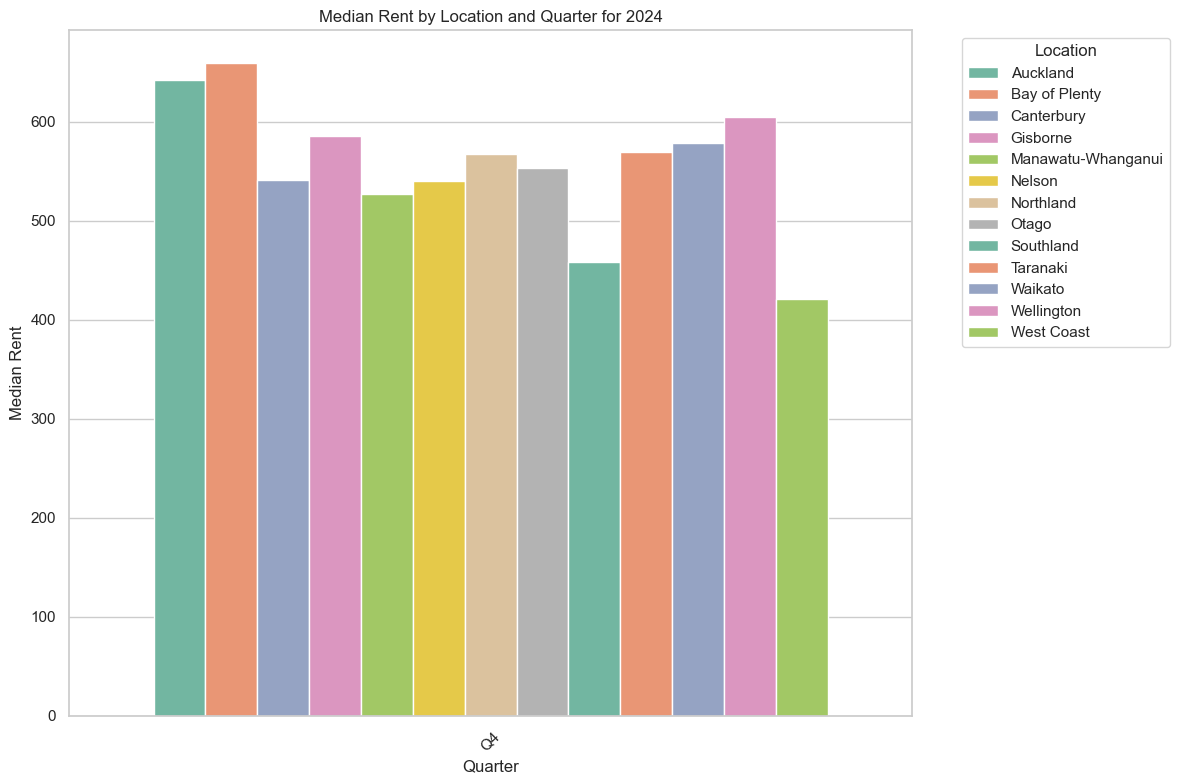


Predicted Rents for 2024:

Location: Auckland
Q4: 642.33

Location: Bay of Plenty
Q4: 659.08

Location: Canterbury
Q4: 540.91

Location: Gisborne
Q4: 585.25

Location: Manawatu-Whanganui
Q4: 527.33

Location: Nelson
Q4: 540.22

Location: Northland
Q4: 567.77

Location: Otago
Q4: 552.87

Location: Southland
Q4: 458.15

Location: Taranaki
Q4: 568.97

Location: Waikato
Q4: 577.92

Location: Wellington
Q4: 604.25

Location: West Coast
Q4: 421.24



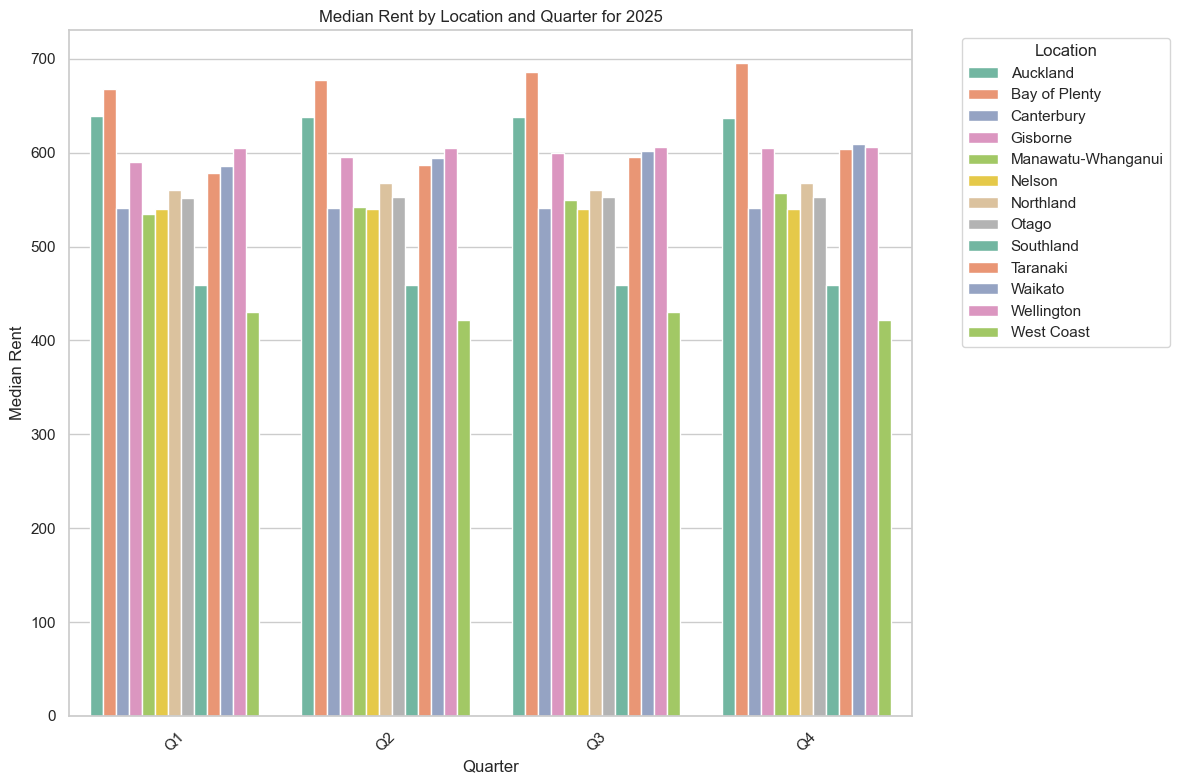


Predicted Rents for 2025:

Location: Auckland
Q1: 639.24
Q2: 637.99
Q3: 637.48
Q4: 637.28

Location: Bay of Plenty
Q1: 668.16
Q2: 677.23
Q3: 686.31
Q4: 695.39

Location: Canterbury
Q1: 540.77
Q2: 540.79
Q3: 540.79
Q4: 540.79

Location: Gisborne
Q1: 590.33
Q2: 595.23
Q3: 599.97
Q4: 604.54

Location: Manawatu-Whanganui
Q1: 534.66
Q2: 541.98
Q3: 549.31
Q4: 556.64

Location: Nelson
Q1: 540.18
Q2: 540.18
Q3: 540.18
Q4: 540.18

Location: Northland
Q1: 560.00
Q2: 567.77
Q3: 560.00
Q4: 567.77

Location: Otago
Q1: 552.10
Q2: 552.30
Q3: 552.25
Q4: 552.26

Location: Southland
Q1: 458.99
Q2: 458.61
Q3: 458.78
Q4: 458.70

Location: Taranaki
Q1: 577.89
Q2: 586.75
Q3: 595.55
Q4: 604.29

Location: Waikato
Q1: 585.83
Q2: 593.75
Q3: 601.67
Q4: 609.58

Location: Wellington
Q1: 605.21
Q2: 605.42
Q3: 605.47
Q4: 605.48

Location: West Coast
Q1: 430.00
Q2: 421.24
Q3: 430.00
Q4: 421.24



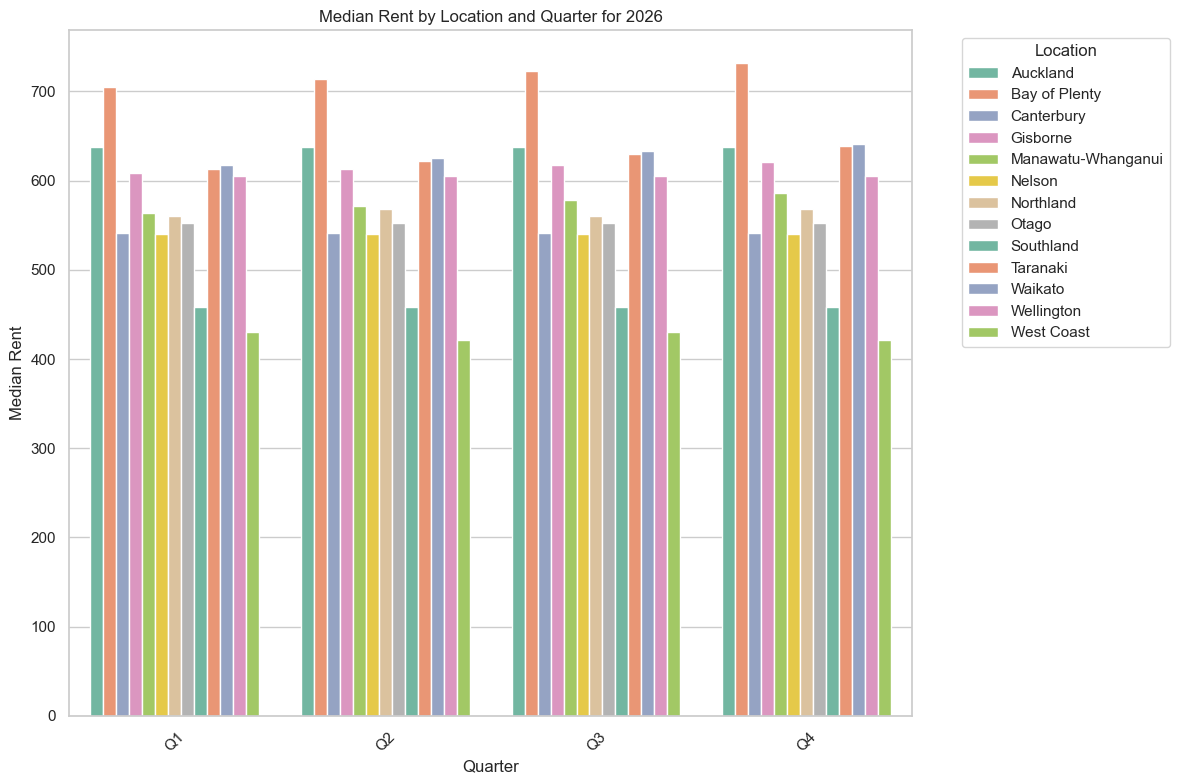


Predicted Rents for 2026:

Location: Auckland
Q1: 637.20
Q2: 637.16
Q3: 637.15
Q4: 637.14

Location: Bay of Plenty
Q1: 704.47
Q2: 713.54
Q3: 722.62
Q4: 731.70

Location: Canterbury
Q1: 540.79
Q2: 540.79
Q3: 540.79
Q4: 540.79

Location: Gisborne
Q1: 608.97
Q2: 613.24
Q3: 617.37
Q4: 621.35

Location: Manawatu-Whanganui
Q1: 563.97
Q2: 571.30
Q3: 578.62
Q4: 585.95

Location: Nelson
Q1: 540.18
Q2: 540.18
Q3: 540.18
Q4: 540.18

Location: Northland
Q1: 560.00
Q2: 567.77
Q3: 560.00
Q4: 567.77

Location: Otago
Q1: 552.26
Q2: 552.26
Q3: 552.26
Q4: 552.26

Location: Southland
Q1: 458.74
Q2: 458.72
Q3: 458.73
Q4: 458.73

Location: Taranaki
Q1: 612.99
Q2: 621.62
Q3: 630.20
Q4: 638.73

Location: Waikato
Q1: 617.50
Q2: 625.41
Q3: 633.33
Q4: 641.25

Location: Wellington
Q1: 605.49
Q2: 605.49
Q3: 605.49
Q4: 605.49

Location: West Coast
Q1: 430.00
Q2: 421.24
Q3: 430.00
Q4: 421.24



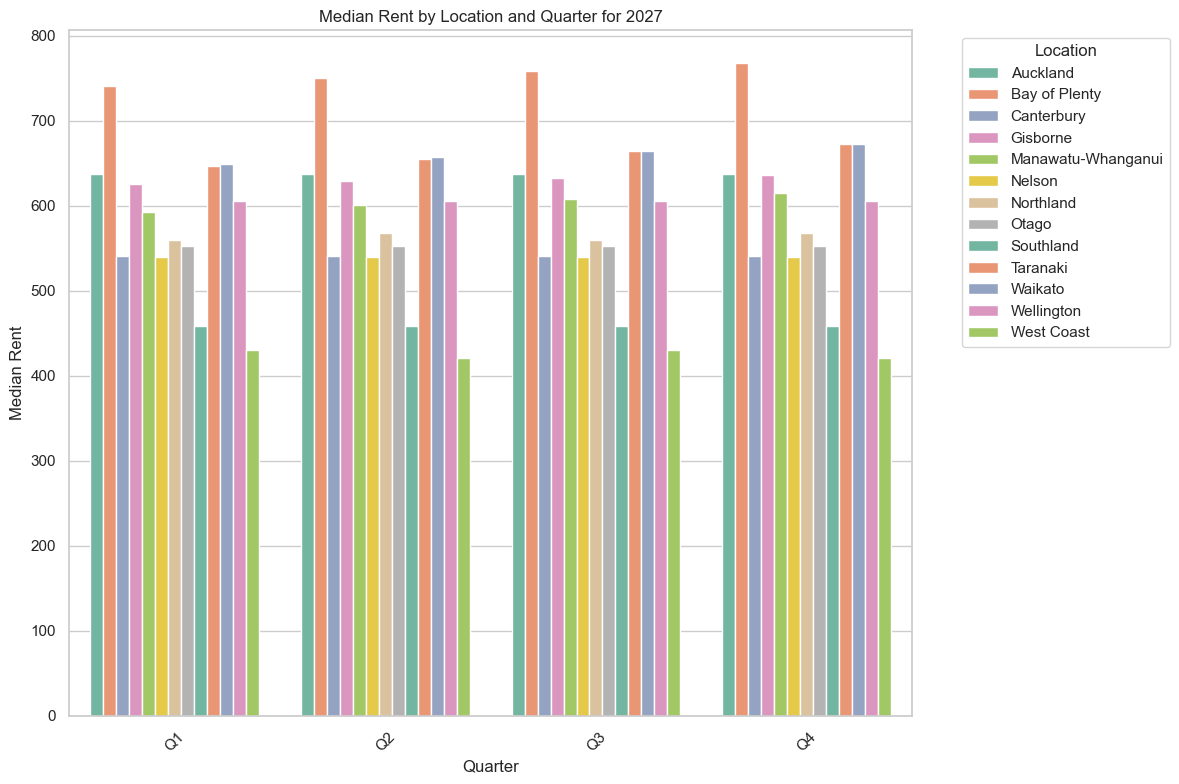


Predicted Rents for 2027:

Location: Auckland
Q1: 637.14
Q2: 637.14
Q3: 637.14
Q4: 637.14

Location: Bay of Plenty
Q1: 740.77
Q2: 749.85
Q3: 758.93
Q4: 768.00

Location: Canterbury
Q1: 540.79
Q2: 540.79
Q3: 540.79
Q4: 540.79

Location: Gisborne
Q1: 625.21
Q2: 628.93
Q3: 632.53
Q4: 636.00

Location: Manawatu-Whanganui
Q1: 593.28
Q2: 600.61
Q3: 607.93
Q4: 615.26

Location: Nelson
Q1: 540.18
Q2: 540.18
Q3: 540.18
Q4: 540.18

Location: Northland
Q1: 560.00
Q2: 567.77
Q3: 560.00
Q4: 567.77

Location: Otago
Q1: 552.26
Q2: 552.26
Q3: 552.26
Q4: 552.26

Location: Southland
Q1: 458.73
Q2: 458.73
Q3: 458.73
Q4: 458.73

Location: Taranaki
Q1: 647.20
Q2: 655.62
Q3: 663.99
Q4: 672.30

Location: Waikato
Q1: 649.16
Q2: 657.08
Q3: 664.99
Q4: 672.91

Location: Wellington
Q1: 605.49
Q2: 605.49
Q3: 605.49
Q4: 605.49

Location: West Coast
Q1: 430.00
Q2: 421.24
Q3: 430.00
Q4: 421.24



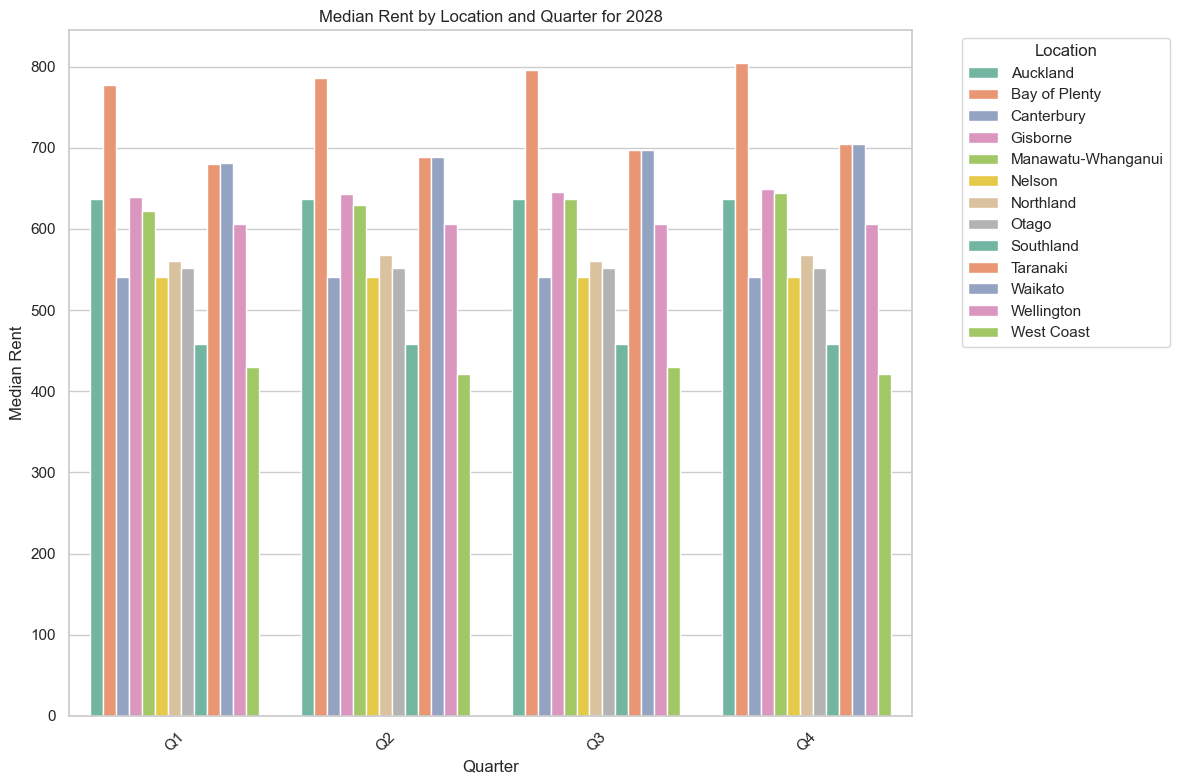


Predicted Rents for 2028:

Location: Auckland
Q1: 637.14
Q2: 637.14
Q3: 637.14
Q4: 637.14

Location: Bay of Plenty
Q1: 777.08
Q2: 786.16
Q3: 795.23
Q4: 804.31

Location: Canterbury
Q1: 540.79
Q2: 540.79
Q3: 540.79
Q4: 540.79

Location: Gisborne
Q1: 639.36
Q2: 642.60
Q3: 645.73
Q4: 648.76

Location: Manawatu-Whanganui
Q1: 622.59
Q2: 629.91
Q3: 637.24
Q4: 644.57

Location: Nelson
Q1: 540.18
Q2: 540.18
Q3: 540.18
Q4: 540.18

Location: Northland
Q1: 560.00
Q2: 567.77
Q3: 560.00
Q4: 567.77

Location: Otago
Q1: 552.26
Q2: 552.26
Q3: 552.26
Q4: 552.26

Location: Southland
Q1: 458.73
Q2: 458.73
Q3: 458.73
Q4: 458.73

Location: Taranaki
Q1: 680.56
Q2: 688.77
Q3: 696.92
Q4: 705.02

Location: Waikato
Q1: 680.83
Q2: 688.74
Q3: 696.66
Q4: 704.57

Location: Wellington
Q1: 605.49
Q2: 605.49
Q3: 605.49
Q4: 605.49

Location: West Coast
Q1: 430.00
Q2: 421.24
Q3: 430.00
Q4: 421.24



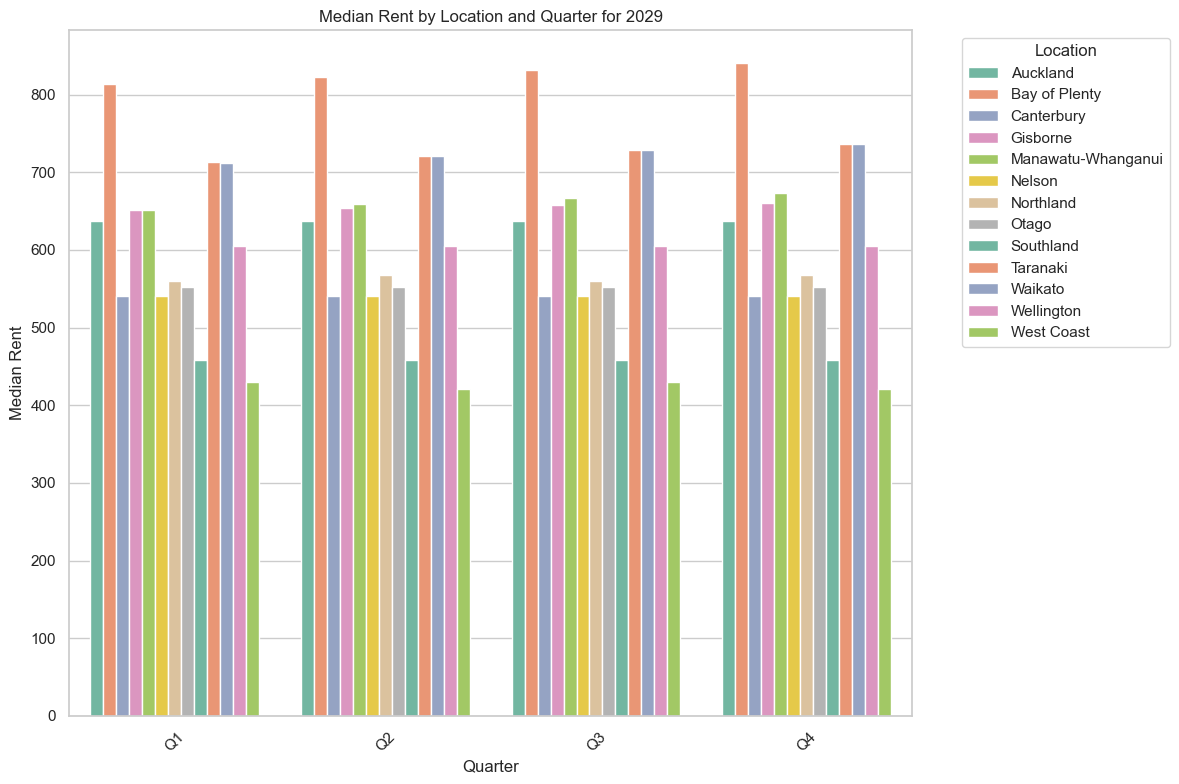


Predicted Rents for 2029:

Location: Auckland
Q1: 637.14
Q2: 637.14
Q3: 637.14
Q4: 637.14

Location: Bay of Plenty
Q1: 813.38
Q2: 822.46
Q3: 831.54
Q4: 840.61

Location: Canterbury
Q1: 540.79
Q2: 540.79
Q3: 540.79
Q4: 540.79

Location: Gisborne
Q1: 651.69
Q2: 654.51
Q3: 657.24
Q4: 659.88

Location: Manawatu-Whanganui
Q1: 651.90
Q2: 659.22
Q3: 666.55
Q4: 673.88

Location: Nelson
Q1: 540.18
Q2: 540.18
Q3: 540.18
Q4: 540.18

Location: Northland
Q1: 560.00
Q2: 567.77
Q3: 560.00
Q4: 567.77

Location: Otago
Q1: 552.26
Q2: 552.26
Q3: 552.26
Q4: 552.26

Location: Southland
Q1: 458.73
Q2: 458.73
Q3: 458.73
Q4: 458.73

Location: Taranaki
Q1: 713.08
Q2: 721.08
Q3: 729.03
Q4: 736.93

Location: Waikato
Q1: 712.49
Q2: 720.40
Q3: 728.32
Q4: 736.24

Location: Wellington
Q1: 605.49
Q2: 605.49
Q3: 605.49
Q4: 605.49

Location: West Coast
Q1: 430.00
Q2: 421.24
Q3: 430.00
Q4: 421.24



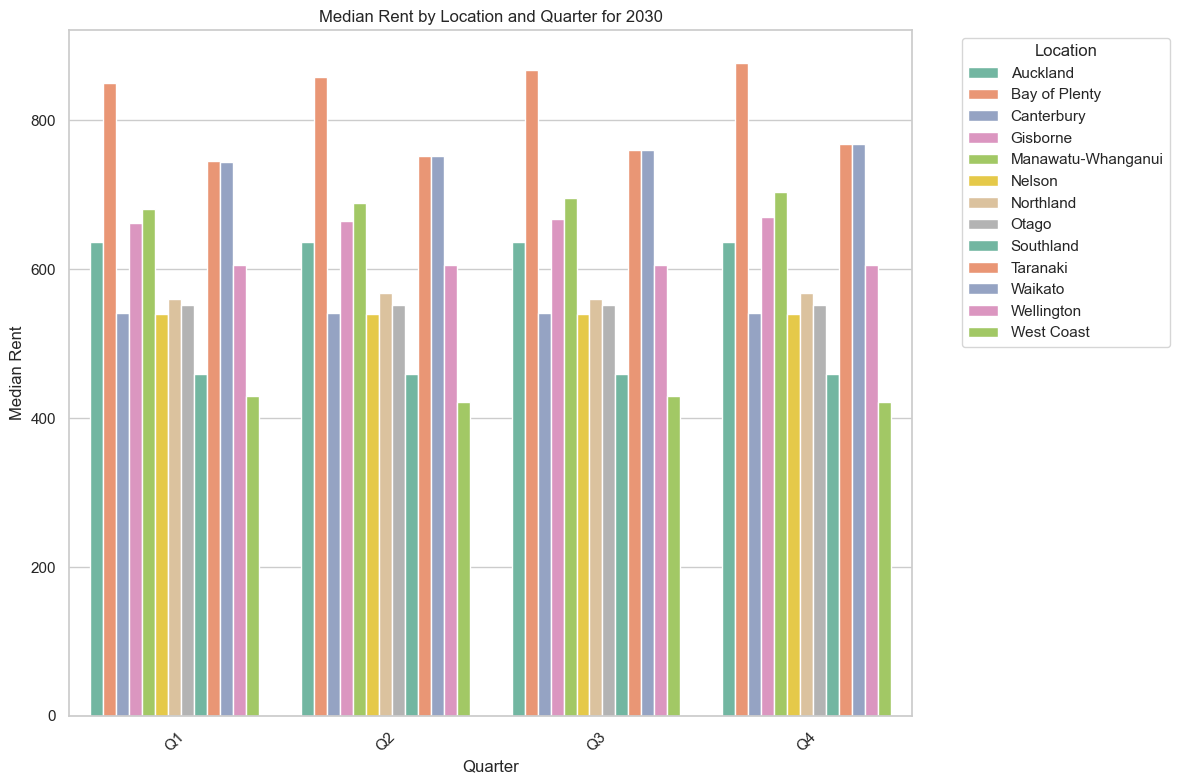


Predicted Rents for 2030:

Location: Auckland
Q1: 637.14
Q2: 637.14
Q3: 637.14
Q4: 637.14

Location: Bay of Plenty
Q1: 849.69
Q2: 858.76
Q3: 867.84
Q4: 876.91

Location: Canterbury
Q1: 540.79
Q2: 540.79
Q3: 540.79
Q4: 540.79

Location: Gisborne
Q1: 662.43
Q2: 664.89
Q3: 667.27
Q4: 669.57

Location: Manawatu-Whanganui
Q1: 681.20
Q2: 688.53
Q3: 695.86
Q4: 703.18

Location: Nelson
Q1: 540.18
Q2: 540.18
Q3: 540.18
Q4: 540.18

Location: Northland
Q1: 560.00
Q2: 567.77
Q3: 560.00
Q4: 567.77

Location: Otago
Q1: 552.26
Q2: 552.26
Q3: 552.26
Q4: 552.26

Location: Southland
Q1: 458.73
Q2: 458.73
Q3: 458.73
Q4: 458.73

Location: Taranaki
Q1: 744.78
Q2: 752.58
Q3: 760.33
Q4: 768.03

Location: Waikato
Q1: 744.15
Q2: 752.07
Q3: 759.98
Q4: 767.90

Location: Wellington
Q1: 605.49
Q2: 605.49
Q3: 605.49
Q4: 605.49

Location: West Coast
Q1: 430.00
Q2: 421.24
Q3: 430.00
Q4: 421.24



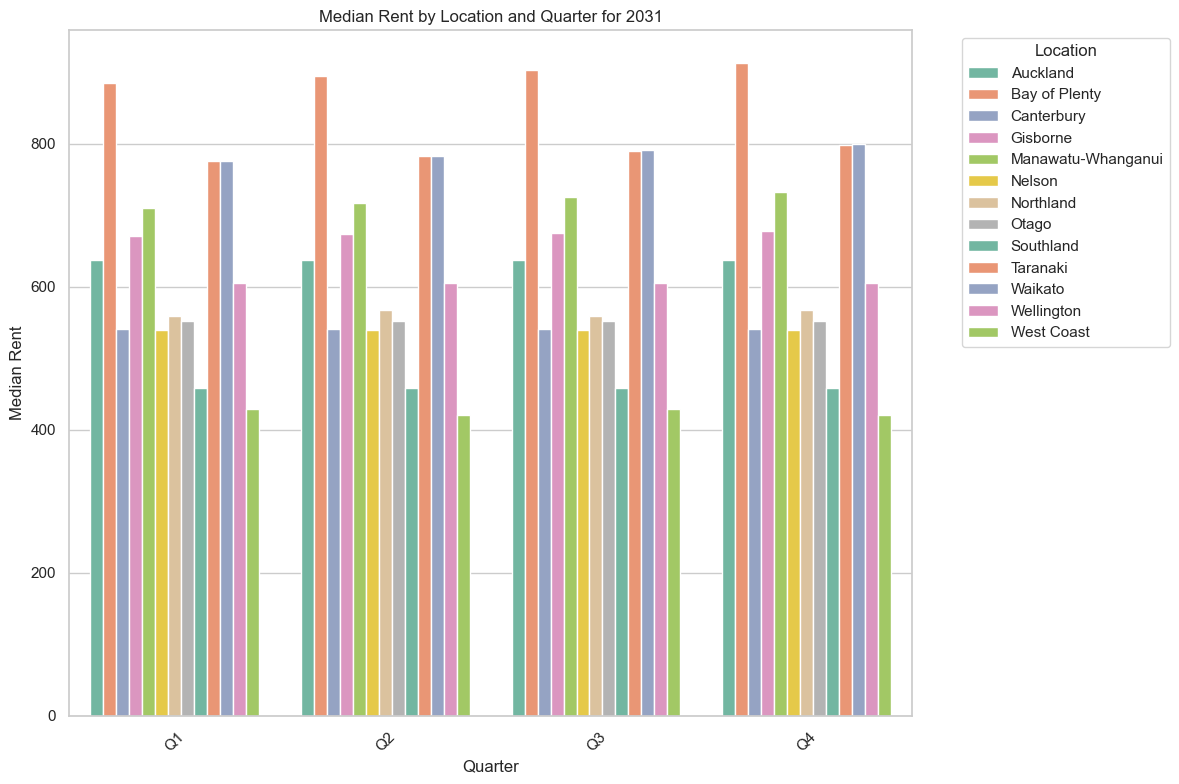


Predicted Rents for 2031:

Location: Auckland
Q1: 637.14
Q2: 637.14
Q3: 637.14
Q4: 637.14

Location: Bay of Plenty
Q1: 885.99
Q2: 895.06
Q3: 904.14
Q4: 913.21

Location: Canterbury
Q1: 540.79
Q2: 540.79
Q3: 540.79
Q4: 540.79

Location: Gisborne
Q1: 671.79
Q2: 673.94
Q3: 676.01
Q4: 678.01

Location: Manawatu-Whanganui
Q1: 710.51
Q2: 717.84
Q3: 725.16
Q4: 732.49

Location: Nelson
Q1: 540.18
Q2: 540.18
Q3: 540.18
Q4: 540.18

Location: Northland
Q1: 560.00
Q2: 567.77
Q3: 560.00
Q4: 567.77

Location: Otago
Q1: 552.26
Q2: 552.26
Q3: 552.26
Q4: 552.26

Location: Southland
Q1: 458.73
Q2: 458.73
Q3: 458.73
Q4: 458.73

Location: Taranaki
Q1: 775.68
Q2: 783.28
Q3: 790.84
Q4: 798.35

Location: Waikato
Q1: 775.81
Q2: 783.73
Q3: 791.64
Q4: 799.56

Location: Wellington
Q1: 605.49
Q2: 605.49
Q3: 605.49
Q4: 605.49

Location: West Coast
Q1: 430.00
Q2: 421.24
Q3: 430.00
Q4: 421.24



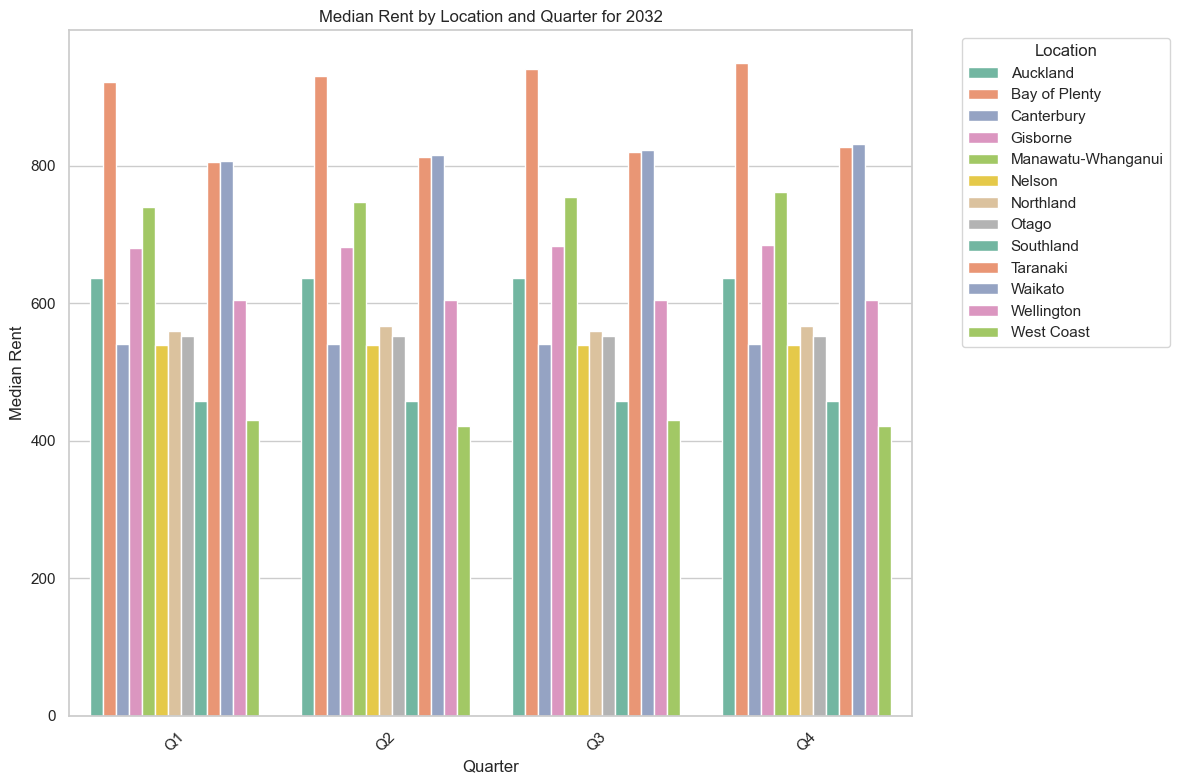


Predicted Rents for 2032:

Location: Auckland
Q1: 637.14
Q2: 637.14
Q3: 637.14
Q4: 637.14

Location: Bay of Plenty
Q1: 922.28
Q2: 931.36
Q3: 940.43
Q4: 949.51

Location: Canterbury
Q1: 540.79
Q2: 540.79
Q3: 540.79
Q4: 540.79

Location: Gisborne
Q1: 679.95
Q2: 681.82
Q3: 683.62
Q4: 685.37

Location: Manawatu-Whanganui
Q1: 739.81
Q2: 747.14
Q3: 754.47
Q4: 761.79

Location: Nelson
Q1: 540.18
Q2: 540.18
Q3: 540.18
Q4: 540.18

Location: Northland
Q1: 560.00
Q2: 567.77
Q3: 560.00
Q4: 567.77

Location: Otago
Q1: 552.26
Q2: 552.26
Q3: 552.26
Q4: 552.26

Location: Southland
Q1: 458.73
Q2: 458.73
Q3: 458.73
Q4: 458.73

Location: Taranaki
Q1: 805.81
Q2: 813.22
Q3: 820.58
Q4: 827.90

Location: Waikato
Q1: 807.48
Q2: 815.39
Q3: 823.31
Q4: 831.22

Location: Wellington
Q1: 605.49
Q2: 605.49
Q3: 605.49
Q4: 605.49

Location: West Coast
Q1: 430.00
Q2: 421.24
Q3: 430.00
Q4: 421.24



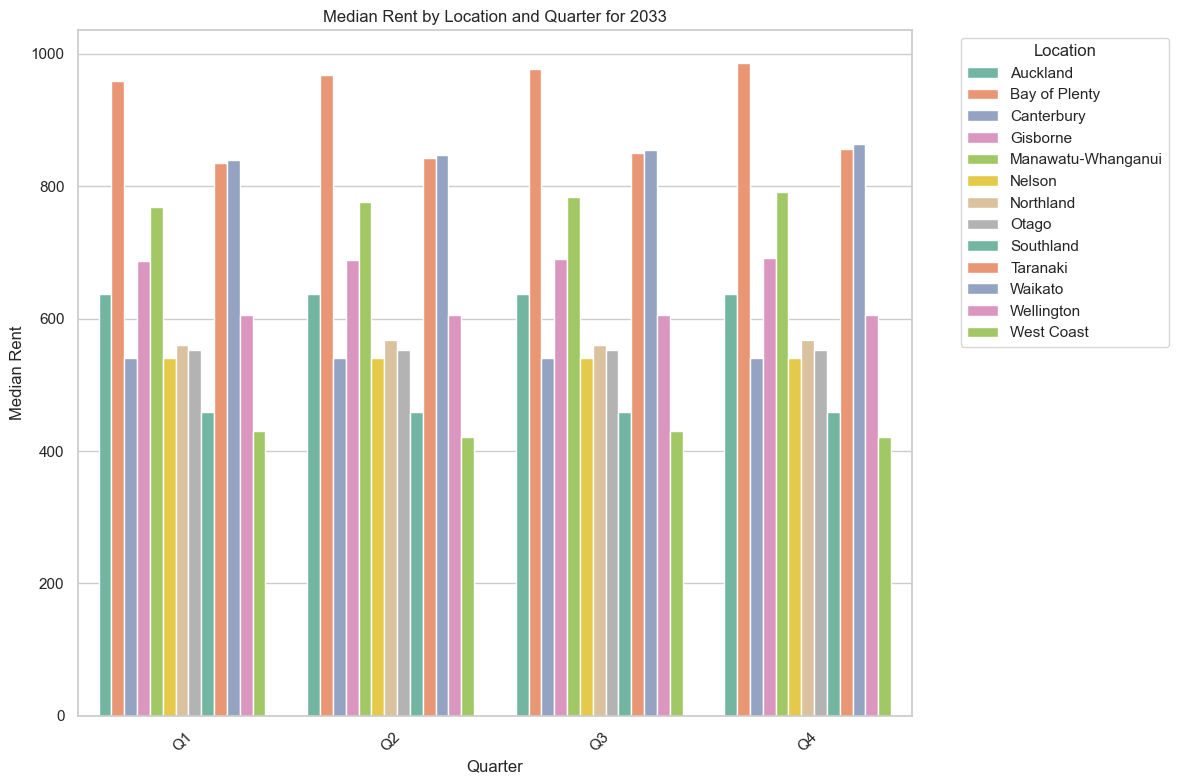


Predicted Rents for 2033:

Location: Auckland
Q1: 637.14
Q2: 637.14
Q3: 637.14
Q4: 637.14

Location: Bay of Plenty
Q1: 958.58
Q2: 967.65
Q3: 976.73
Q4: 985.80

Location: Canterbury
Q1: 540.79
Q2: 540.79
Q3: 540.79
Q4: 540.79

Location: Gisborne
Q1: 687.05
Q2: 688.68
Q3: 690.26
Q4: 691.78

Location: Manawatu-Whanganui
Q1: 769.12
Q2: 776.44
Q3: 783.77
Q4: 791.10

Location: Nelson
Q1: 540.18
Q2: 540.18
Q3: 540.18
Q4: 540.18

Location: Northland
Q1: 560.00
Q2: 567.77
Q3: 560.00
Q4: 567.77

Location: Otago
Q1: 552.26
Q2: 552.26
Q3: 552.26
Q4: 552.26

Location: Southland
Q1: 458.73
Q2: 458.73
Q3: 458.73
Q4: 458.73

Location: Taranaki
Q1: 835.17
Q2: 842.40
Q3: 849.58
Q4: 856.72

Location: Waikato
Q1: 839.14
Q2: 847.05
Q3: 854.97
Q4: 862.88

Location: Wellington
Q1: 605.49
Q2: 605.49
Q3: 605.49
Q4: 605.49

Location: West Coast
Q1: 430.00
Q2: 421.24
Q3: 430.00
Q4: 421.24



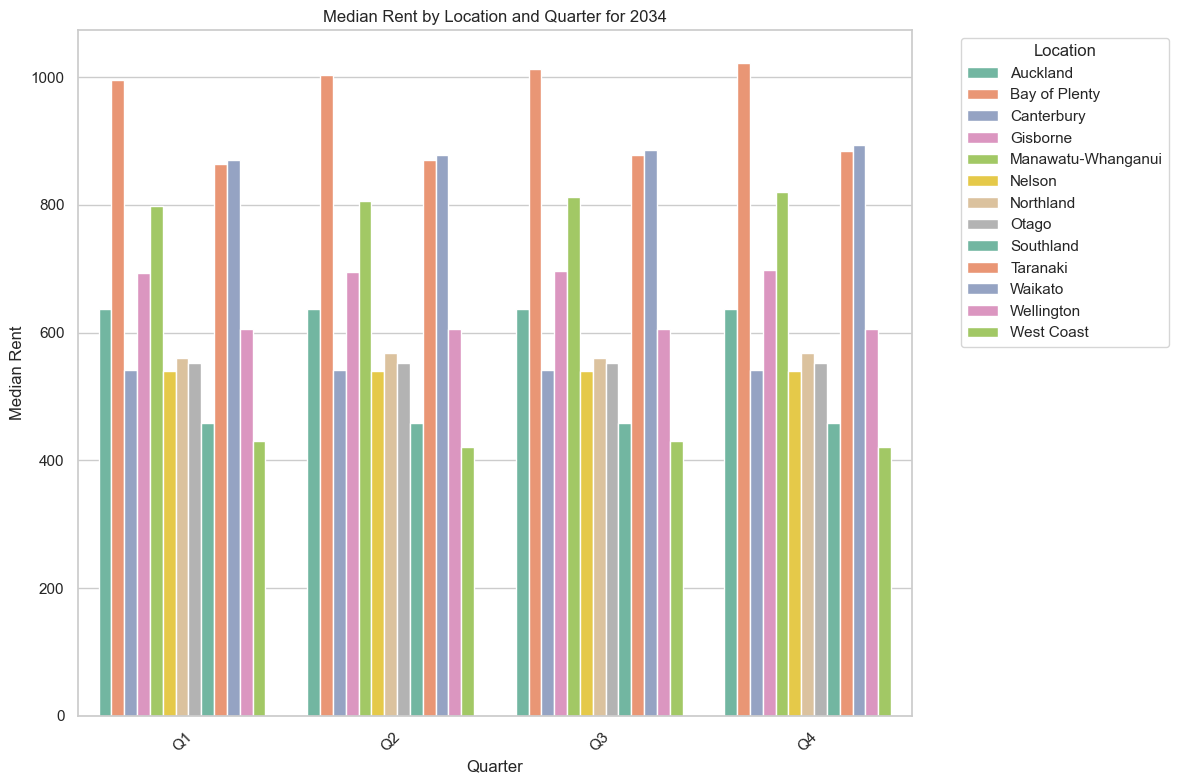


Predicted Rents for 2034:

Location: Auckland
Q1: 637.14
Q2: 637.14
Q3: 637.14
Q4: 637.14

Location: Bay of Plenty
Q1: 994.87
Q2: 1003.95
Q3: 1013.02
Q4: 1022.09

Location: Canterbury
Q1: 540.79
Q2: 540.79
Q3: 540.79
Q4: 540.79

Location: Gisborne
Q1: 693.25
Q2: 694.67
Q3: 696.04
Q4: 697.36

Location: Manawatu-Whanganui
Q1: 798.42
Q2: 805.75
Q3: 813.07
Q4: 820.40

Location: Nelson
Q1: 540.18
Q2: 540.18
Q3: 540.18
Q4: 540.18

Location: Northland
Q1: 560.00
Q2: 567.77
Q3: 560.00
Q4: 567.77

Location: Otago
Q1: 552.26
Q2: 552.26
Q3: 552.26
Q4: 552.26

Location: Southland
Q1: 458.73
Q2: 458.73
Q3: 458.73
Q4: 458.73

Location: Taranaki
Q1: 863.81
Q2: 870.85
Q3: 877.85
Q4: 884.81

Location: Waikato
Q1: 870.80
Q2: 878.71
Q3: 886.63
Q4: 894.54

Location: Wellington
Q1: 605.49
Q2: 605.49
Q3: 605.49
Q4: 605.49

Location: West Coast
Q1: 430.00
Q2: 421.24
Q3: 430.00
Q4: 421.24



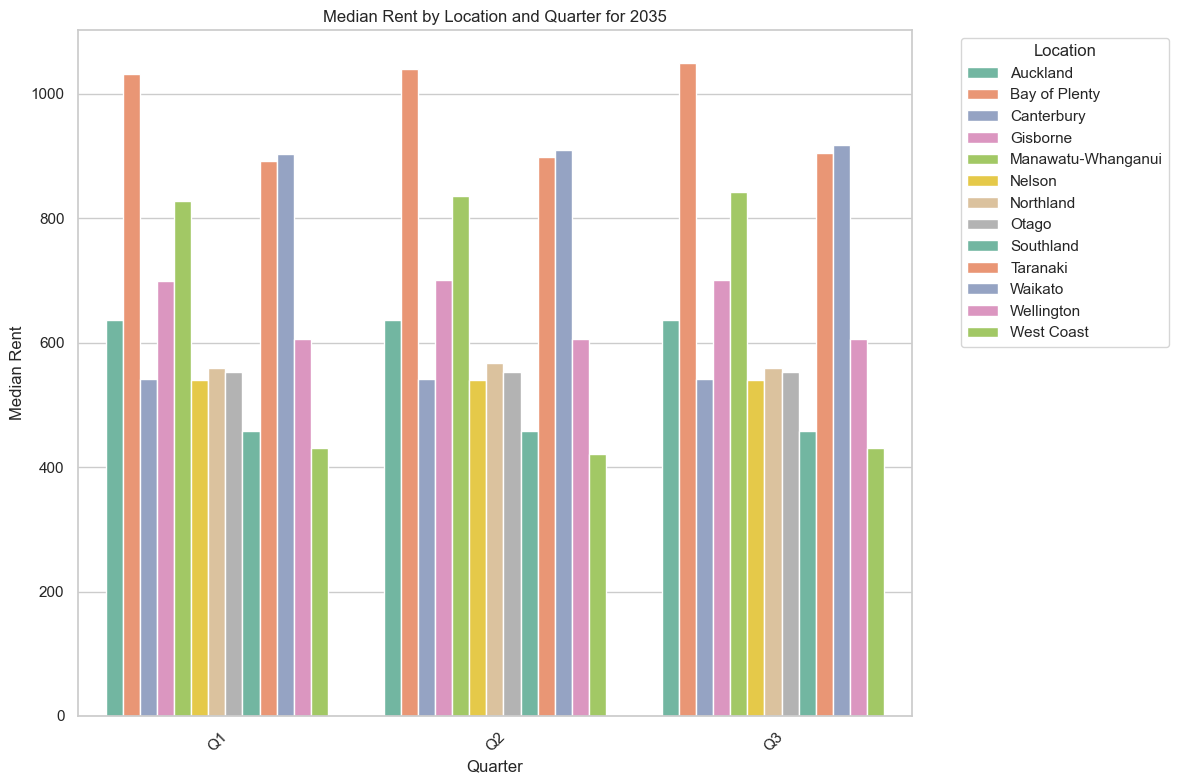


Predicted Rents for 2035:

Location: Auckland
Q1: 637.14
Q2: 637.14
Q3: 637.14

Location: Bay of Plenty
Q1: 1031.16
Q2: 1040.24
Q3: 1049.31

Location: Canterbury
Q1: 540.79
Q2: 540.79
Q3: 540.79

Location: Gisborne
Q1: 698.64
Q2: 699.88
Q3: 701.07

Location: Manawatu-Whanganui
Q1: 827.72
Q2: 835.05
Q3: 842.37

Location: Nelson
Q1: 540.18
Q2: 540.18
Q3: 540.18

Location: Northland
Q1: 560.00
Q2: 567.77
Q3: 560.00

Location: Otago
Q1: 552.26
Q2: 552.26
Q3: 552.26

Location: Southland
Q1: 458.73
Q2: 458.73
Q3: 458.73

Location: Taranaki
Q1: 891.72
Q2: 898.58
Q3: 905.41

Location: Waikato
Q1: 902.46
Q2: 910.37
Q3: 918.29

Location: Wellington
Q1: 605.49
Q2: 605.49
Q3: 605.49

Location: West Coast
Q1: 430.00
Q2: 421.24
Q3: 430.00



In [37]:
df = pd.read_csv('rent_crime_monthly.csv')
df['Time Frame'] = pd.to_datetime(df['Time Frame'])
le_location = LabelEncoder()
df['Location'] = le_location.fit_transform(df['Location'])
df = df[df['Time Frame'] >= '2020-01-01']

N = 3  # Number of past values to include
forecast_horizon_2035 = 44  # Forecasting 44 quarters (11 years)
predictions_2035 = []

for loc in le_location.classes_:
    loc_encoded = le_location.transform([loc])[0]
    loc_data = df[df['Location'] == loc_encoded].set_index('Time Frame').resample('Q').mean()['Median Rent']
    
    loc_df = pd.DataFrame({'Median Rent': loc_data})
    for i in range(1, N + 1):
        loc_df[f'lag_{i}'] = loc_data.shift(i)
    loc_df.dropna(inplace=True)
    y = loc_df['Median Rent']

    model = ARIMA(y, order=(1, 1, 1))
    model_fit = model.fit()

    forecast_2035 = model_fit.get_forecast(steps=forecast_horizon_2035)
    predicted_rent_2035 = forecast_2035.predicted_mean

    for i, pred in enumerate(predicted_rent_2035):
        forecast_date = pd.date_range(start=loc_data.index[-1] + pd.DateOffset(months=(i + 1) * 3), periods=1)[0]
        year, quarter = forecast_date.year, (forecast_date.month - 1) // 3 + 1
        predictions_2035.append({'Location': loc, 'Year': year, 'Quarter': f'Q{quarter}', 'Median Rent': pred})

quarterly_rent = pd.DataFrame(predictions_2035)
quarterly_rent = quarterly_rent[quarterly_rent['Year'] >= 2020]

# Create bar plots for each year from 2020 to 2035
for year in quarterly_rent['Year'].unique():
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Quarter', y='Median Rent', hue='Location', data=quarterly_rent[quarterly_rent['Year'] == year], palette='Set2')
    
    plt.title(f'Median Rent by Location and Quarter for {year}')
    plt.xlabel('Quarter')
    plt.ylabel('Median Rent')
    
    plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"\nPredicted Rents for {year}:\n")
    for location in quarterly_rent['Location'].unique():
        print(f"Location: {location}")
        location_data = quarterly_rent[(quarterly_rent['Year'] == year) & (quarterly_rent['Location'] == location)]
        for _, row in location_data.iterrows():
            print(f"{row['Quarter']}: {row['Median Rent']:.2f}")
        print("="*40 + "\n")


## 5. AWS

Dataset:
- rent_crime_monthly
- rent_crime_yearly

Feature Selection: 
- Time Frame
- Location Id	
- Crime

The target variables can be each of the rental-related metrics:
- Median Rent

In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from sklearn.preprocessing import OneHotEncoder
import scipy.interpolate as inter
import boto3
import io
import os
import sagemaker
from sagemaker.parameter import (
    CategoricalParameter,
    ContinuousParameter,
    IntegerParameter,
    ParameterRange
)
from sagemaker.image_uris import retrieve
import seaborn as sns
from sagemaker.tuner import HyperparameterTuner
from pprint import pprint
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from sagemaker.estimator import Estimator
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
from sagemaker import AutoML
from sagemaker import get_execution_role

### 5.1 Monthly Crime

#### 5.1.1 Hyperparameters

Location Id can represent a location, so only the Location Id is kept to distinguish between different regions.

In [29]:
url_data = "s3://c125236a3097401l7846476t1w2750781236-sandboxbucket-eseae6ok8hd4/rent_crime_monthly.csv"
rent_crime_monthly = pd.read_csv(url_data)
rent_crime_monthly = rent_crime_monthly.drop(columns = ['Location'])

The data will be processed separately, classified by region.

In [31]:
rent_crime_monthly_grouped = rent_crime_monthly.groupby('Location Id')
rent_crime_monthly['Crime_Rolling_Mean_3'] = rent_crime_monthly_grouped['Crime'].apply(lambda x: x.rolling(3,1).mean()).reset_index(level=0, drop=True)
rent_crime_monthly['Crime_Rolling_Mean_6'] = rent_crime_monthly_grouped['Crime'].apply(lambda x: x.rolling(6,1).mean()).reset_index(level=0, drop=True)
rent_crime_monthly['Crime_Rolling_Mean_12'] = rent_crime_monthly_grouped['Crime'].apply(lambda x: x.rolling(12,1).mean()).reset_index(level=0, drop=True)
rent_crime_monthly['Crime_Rolling_Std_3'] = rent_crime_monthly_grouped['Crime'].apply(lambda x: x.rolling(3,1).std()).reset_index(level=0, drop=True)
rent_crime_monthly['Crime_Rolling_Std_6'] = rent_crime_monthly_grouped['Crime'].apply(lambda x: x.rolling(6,1).std()).reset_index(level=0, drop=True)
rent_crime_monthly['Crime_Rolling_Std_12'] = rent_crime_monthly_grouped['Crime'].apply(lambda x: x.rolling(12,1).std()).reset_index(level=0, drop=True)
rent_crime_monthly['Crime_Shift_1'] = rent_crime_monthly_grouped['Crime'].apply(lambda x: x.shift(1)).reset_index(level=0, drop=True)
rent_crime_monthly['Crime_Shift_2'] = rent_crime_monthly_grouped['Crime'].apply(lambda x: x.shift(2)).reset_index(level=0, drop=True)
rent_crime_monthly.dropna(inplace=True)

In [33]:
rent_crime_monthly['Time Frame'] = pd.to_datetime(rent_crime_monthly['Time Frame'])
rent_crime_monthly.set_index('Time Frame', inplace=True)

The two most correlated variables are selected to train the model.However, all of the variables have little correlation with rents.

In [36]:
correlation_matrix = rent_crime_monthly.corr()
correlation_matrix['Median Rent'].sort_values()

Location Id             -0.136134
Crime                   -0.062997
Crime_Rolling_Mean_3    -0.060479
Crime_Shift_1           -0.060476
Crime_Shift_2           -0.057945
Crime_Rolling_Mean_6    -0.056675
Crime_Rolling_Mean_12   -0.048827
Crime_Rolling_Std_12     0.229875
Crime_Rolling_Std_6      0.241557
Crime_Rolling_Std_3      0.254265
Median Rent              1.000000
Name: Median Rent, dtype: float64

In [40]:
rent_crime_monthly = rent_crime_monthly[['Median Rent','Location Id','Crime_Rolling_Std_3','Crime_Rolling_Std_6']]

In [43]:
rent_crime_train = rent_crime_monthly[rent_crime_monthly.index < dt.datetime(year=2018, month=1, day=1)].copy()
rent_crime_validation = rent_crime_monthly[(rent_crime_monthly.index >= dt.datetime(year=2018, month=1, day=1)) & (rent_crime_monthly.index < dt.datetime(year=2021, month=1, day=1))].copy()
rent_crime_test = rent_crime_monthly[rent_crime_monthly.index >= dt.datetime(year=2021, month=1, day=1)].copy()

Upload the handled dataset to the S3 storage bucket

In [44]:
bucket='c125236a3097401l7846476t1w2750781236-sandboxbucket-eseae6ok8hd4'
prefix='hyperparam'
train_file='rent_crime_train.csv'
test_file='rent_crime_test.csv'
validate_file='rent_crime_validation.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', rent_crime_train)
upload_s3_csv(test_file, 'test', rent_crime_test)
upload_s3_csv(validate_file, 'validate', rent_crime_validation)

In [45]:

container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

s3_output_location="s3://{}/{}/output/".format(bucket,prefix)

In [46]:
hyperparams = {
    "num_round": "100",
    "objective": "reg:squarederror" 
}

Configuring and initialising XGBoost models

In [47]:
xgb_model = sagemaker.estimator.Estimator(container,
                                          sagemaker.get_execution_role(),
                                          instance_count=1,
                                          instance_type='ml.m4.xlarge',
                                          output_path=s3_output_location,
                                          hyperparameters=hyperparams,
                                          sagemaker_session=sagemaker.Session())

In [48]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

Hyperparameter tuning for alpha, eta, min_child_weight, subsample, num_round.The optimization process tries to find the smallest rmse.

In [49]:
container = retrieve('xgboost', boto3.Session().region_name, '1.0-1')

hyperparameter_ranges = {
    'alpha': ContinuousParameter(0, 1000),
    'eta': ContinuousParameter(0.1, 0.5),
    'min_child_weight': ContinuousParameter(1, 120),
    'subsample': ContinuousParameter(0.5, 1),
    'num_round': IntegerParameter(1, 2000)
}

objective_metric_name = 'validation:rmse'
objective_type = 'Minimize'

tuner = HyperparameterTuner(
    xgb_model,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=100,
    max_parallel_jobs=1,
    objective_type=objective_type
)

tuner.fit(inputs=data_channels, include_cls_metadata=False)
tuner.wait()

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [50]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

'Completed' indicates that the tuning process has been completed. 

Look at the results of the tuning.

In [51]:
tuner_analytics = HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())

df_tuning_job_analytics = tuner_analytics.dataframe()

df_tuning_job_analytics.sort_values(
    by=['FinalObjectiveValue'],
    inplace=True,
    ascending=True)

df_tuning_job_analytics.head()


,alpha,eta,min_child_weight,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
9,0.0,0.358278,120.0,19.0,0.5,sagemaker-xgboost-241007-2025-091-9b128ce1,Completed,174.992401,2024-10-07 21:49:17+00:00,2024-10-07 21:49:51+00:00,34.0
12,0.0,0.356203,120.0,19.0,0.5,sagemaker-xgboost-241007-2025-088-6c9a919f,Completed,175.030441,2024-10-07 21:46:49+00:00,2024-10-07 21:47:18+00:00,29.0
21,0.0,0.356840,120.0,20.0,0.5,sagemaker-xgboost-241007-2025-079-d5c09dd5,Completed,175.138611,2024-10-07 21:38:40+00:00,2024-10-07 21:39:14+00:00,34.0
25,0.0,0.354545,120.0,20.0,0.5,sagemaker-xgboost-241007-2025-075-36ec9b51,Completed,175.239517,2024-10-07 21:35:00+00:00,2024-10-07 21:35:35+00:00,35.0
15,0.0,0.352364,120.0,19.0,0.5,sagemaker-xgboost-241007-2025-085-2ba6293d,Completed,175.318634,2024-10-07 21:44:01+00:00,2024-10-07 21:44:35+00:00,34.0


After that, I obtained the best training job and created the model based on it. Then I deployed the model.

In [52]:
attached_tuner = HyperparameterTuner.attach(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())
best_training_job = attached_tuner.best_training_job()

In [53]:
best_training_job

'sagemaker-xgboost-241007-2025-091-9b128ce1'

In [54]:

algo_estimator = Estimator.attach(best_training_job)

best_algo_model = algo_estimator.create_model(env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"})


2024-10-07 21:50:13 Starting - Found matching resource for reuse
2024-10-07 21:50:13 Downloading - Downloading the training image
2024-10-07 21:50:13 Training - Training image download completed. Training in progress.
2024-10-07 21:50:13 Uploading - Uploading generated training model
2024-10-07 21:50:13 Completed - Resource reused by training job: sagemaker-xgboost-241007-2025-092-9de0f27f


In [55]:
predictor = best_algo_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

------!

Following, I read the test set I just uploaded and get the features. 

In [56]:
s3_client = boto3.client('s3')
bucket_name='c125236a3097401l7846476t1w2750781236-sandboxbucket-eseae6ok8hd4'
file_key = 'hyperparam/test/rent_crime_test.csv' 

response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
test_data = pd.read_csv(response['Body'], header=None)
test_data.columns = ['Median Rent','Location Id','Crime_Rolling_Std_3','Crime_Rolling_Std_6']

features = test_data.drop(columns=['Median Rent'])
actual_values = test_data['Median Rent']

Convert feature data to CSV format and send to model for prediction. Finally, decode and extract the prediction results into a one-dimensional array.

In [57]:
csv_buffer = io.StringIO()
features.to_csv(csv_buffer, header=False, index=False)

csv_bytes = csv_buffer.getvalue().encode('utf-8')
predictions = predictor.predict(csv_bytes, initial_args={"ContentType": "text/csv"})

In [58]:
predicted_values = pd.read_csv(io.StringIO(predictions.decode('utf-8')), header=None).values.flatten()

In [59]:
mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
metrics_df = pd.DataFrame({
    'MSE': [mse],
    'MAE': [mae],
    'MAPE': [mape]
})
metrics_df

,MSE,MAE,MAPE
0,79210.338765,275.097195,0.545191


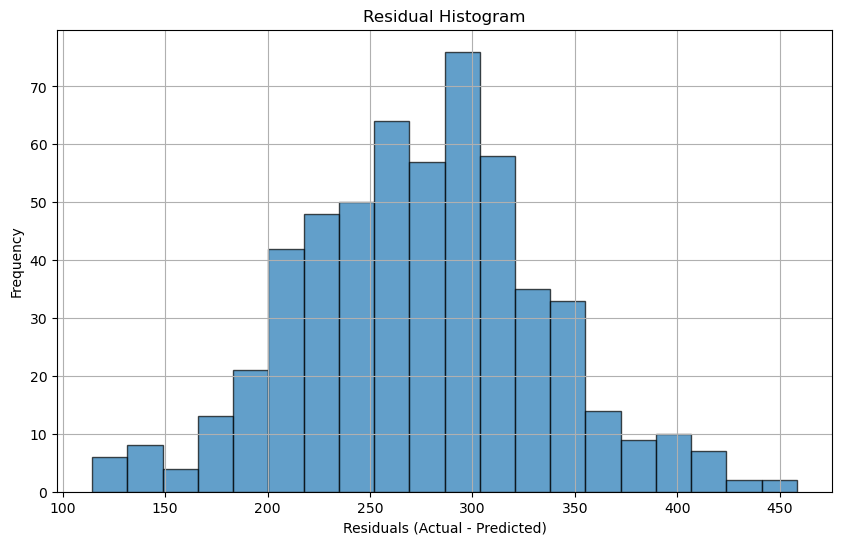

In [60]:
residuals = actual_values - predicted_values
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
plt.title('Residual Histogram')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

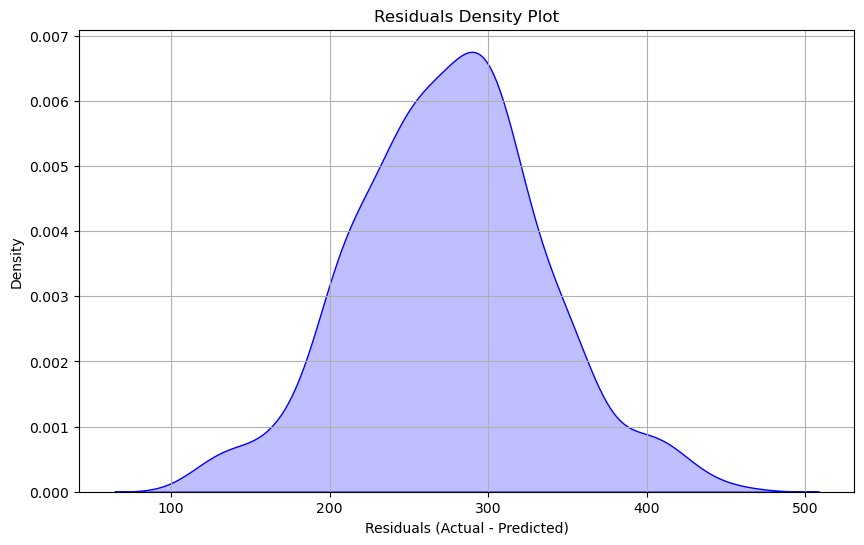

In [61]:
plt.figure(figsize=(10, 6))
sns.kdeplot(residuals, fill=True, color='b')
plt.title('Residuals Density Plot')
plt.xlabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()

The resulting MSE, MAE, and MAPE are all very high. And the residuals are also concentrated around 300, and the highest even reaches 450. This indicates that the model is not performing well. This may be due to the fact that the independent and dependent variables are not highly correlated.

#### 5.1.2 Autopilot

In [25]:
url_data = "s3://c125236a3097401l7846476t1w2750781236-sandboxbucket-zceqpzjq7ylu/rent_crime_monthly.csv"
rent_crime_monthly = pd.read_csv(url_data)
rent_crime_monthly = rent_crime_monthly.drop(columns = ['Location'])

In [26]:
rent_crime_monthly_grouped = rent_crime_monthly.groupby('Location Id')
rent_crime_monthly['Crime_Rolling_Std_3'] = rent_crime_monthly_grouped['Crime'].apply(lambda x: x.rolling(3,1).std()).reset_index(level=0, drop=True)
rent_crime_monthly['Crime_Rolling_Std_6'] = rent_crime_monthly_grouped['Crime'].apply(lambda x: x.rolling(6,1).std()).reset_index(level=0, drop=True)
rent_crime_monthly.dropna(inplace=True)

In [27]:
rent_crime_monthly['Time Frame'] = pd.to_datetime(rent_crime_monthly['Time Frame'])
rent_crime_monthly.set_index('Time Frame', inplace=True)

In [28]:
rent_crime_monthly = rent_crime_monthly[['Median Rent','Location Id','Crime_Rolling_Std_3','Crime_Rolling_Std_6']]

In [29]:
rent_crime_train = rent_crime_monthly[rent_crime_monthly.index < dt.datetime(year=2018, month=1, day=1)].copy()
rent_crime_validation = rent_crime_monthly[(rent_crime_monthly.index >= dt.datetime(year=2018, month=1, day=1)) & (rent_crime_monthly.index < dt.datetime(year=2021, month=1, day=1))].copy()
rent_crime_test = rent_crime_monthly[rent_crime_monthly.index >= dt.datetime(year=2021, month=1, day=1)].copy()

In [30]:
bucket='c125236a3097401l7846476t1w2750781236-sandboxbucket-zceqpzjq7ylu'
prefix='hyperparam'
train_file='rent_crime_train.csv'
test_file='rent_crime_test.csv'
validate_file='rent_crime_validation.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=True, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', rent_crime_train)
upload_s3_csv(test_file, 'test', rent_crime_test)
upload_s3_csv(validate_file, 'validate', rent_crime_validation)

In [31]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
train_data_uri = f's3://{bucket}/{prefix}/train/rent_crime_train.csv'
output_uri = f's3://{bucket}/{prefix}/output/'
job_name = 'rent-crime-autopilot-job'
max_candidates = 100 

I use AutoML to automatically train and tune a machine learning model for a regression task and use MSE as the optimization objective.

In [33]:
automl_job = AutoML(
    role=role,
    target_attribute_name='Median Rent',  
    output_path=output_uri,
    problem_type='Regression', 
    job_objective={'MetricName': 'MSE'},  
    max_candidates=max_candidates,
    sagemaker_session=sagemaker_session
)


automl_job.fit(
    inputs=train_data_uri,
    wait=True,
    logs='All',
    job_name=job_name
)

.................................................................................................................................................................................................................................................................................
..

View the best models

In [34]:
sagemaker_session = sagemaker.Session()
best_candidate = automl_job.describe_auto_ml_job()['BestCandidate']
best_candidate_name = best_candidate['CandidateName']
print("Best Candidate Name: ", best_candidate_name)

Best Candidate Name:  rent-crime-autopilot-jobztjLFEQZ-050-b48dd428


After that, I obtained the best training job and created the model based on it. Then I deployed the model.

In [35]:
from sagemaker.estimator import Estimator
algo_estimator = Estimator.attach(best_candidate_name)
best_algo_model = algo_estimator.create_model(env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"})


2024-10-08 23:34:32 Starting - Found matching resource for reuse
2024-10-08 23:34:32 Downloading - Downloading the training image
2024-10-08 23:34:32 Training - Training image download completed. Training in progress.
2024-10-08 23:34:32 Uploading - Uploading generated training model
2024-10-08 23:34:32 Completed - Resource reused by training job: rent-crime-autopilot-jobztjLFEQZ-060-e3d37db7


In [36]:
predictor = best_algo_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

--------!

In [41]:
s3_client = boto3.client('s3')
bucket_name='c125236a3097401l7846476t1w2750781236-sandboxbucket-zceqpzjq7ylu'
file_key = 'hyperparam/test/rent_crime_test.csv' 

response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
test_data = pd.read_csv(response['Body'])

features = test_data.drop(columns=['Median Rent'])
actual_values = test_data['Median Rent']

In [43]:
csv_buffer = io.StringIO()
features.to_csv(csv_buffer, header=False, index=False)

csv_bytes = csv_buffer.getvalue().encode('utf-8')
predictions = predictor.predict(csv_bytes, initial_args={"ContentType": "text/csv"})

In [44]:
predicted_values = pd.read_csv(io.StringIO(predictions.decode('utf-8')), header=None).values.flatten()

In [45]:
mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
metrics_df = pd.DataFrame({
    'MSE': [mse],
    'MAE': [mae],
    'MAPE': [mape]
})
metrics_df

,MSE,MAE,MAPE
0,45577.800721,199.004536,0.379788


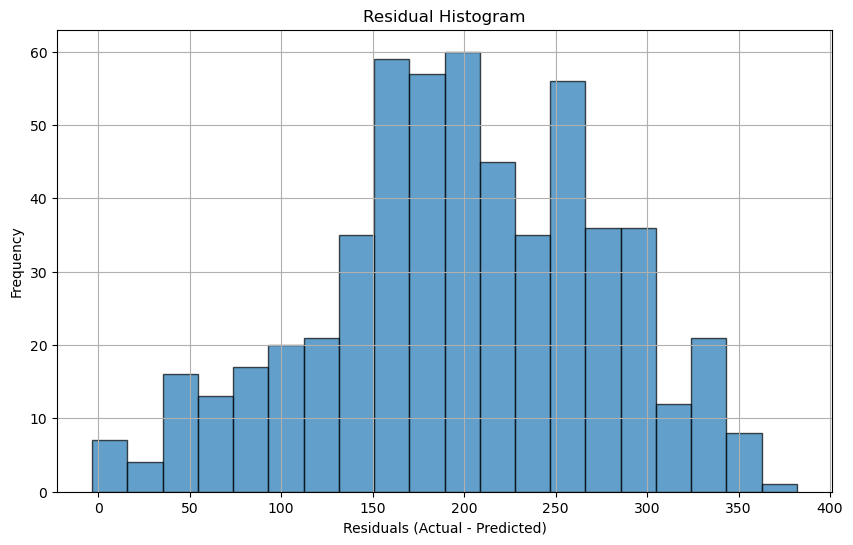

In [46]:
residuals = actual_values - predicted_values
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
plt.title('Residual Histogram')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

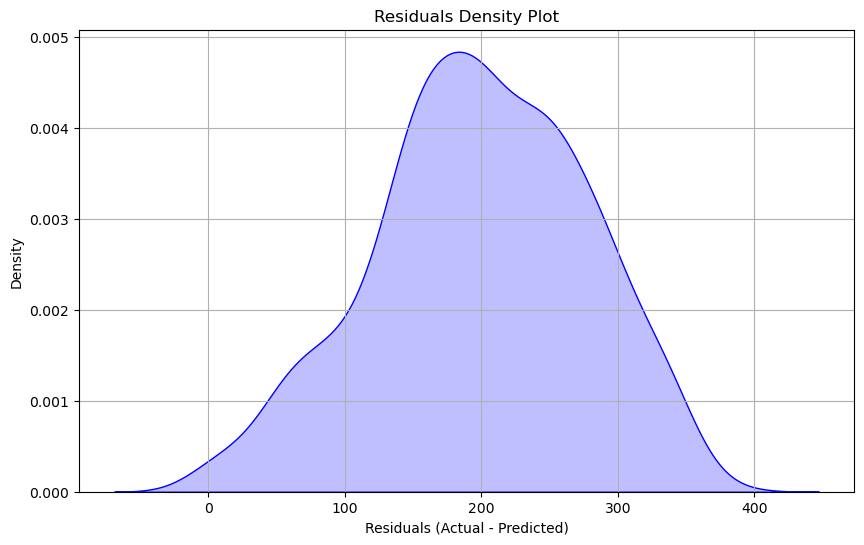

In [47]:
plt.figure(figsize=(10, 6))
sns.kdeplot(residuals, fill=True, color='b')
plt.title('Residuals Density Plot')
plt.xlabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()

This model is much better than the last one but the MSE, MAE, and MAPE are still very high. The residual concentration at 200 is also high.

### 5.2 Yearly Crime

#### 5.2.1 Hyperparameter

Try using yearly crime data to predict the average rent per year.

In [57]:
url_data = "s3://c125236a3097401l7846476t1w2750781236-sandboxbucket-yvdgawzbrlvx/rent_crime_yearly.csv"
rent_crime_yearly = pd.read_csv(url_data)
rent_crime_yearly = rent_crime_yearly.drop(columns = ['Location'])

In [58]:
rent_crime_yearly_grouped = rent_crime_yearly.groupby('Location Id')
rent_crime_yearly['Crime_Rolling_Mean_3'] = rent_crime_yearly_grouped['Crime'].apply(lambda x: x.rolling(3,1).mean()).reset_index(level=0, drop=True)
rent_crime_yearly['Crime_Rolling_Mean_6'] = rent_crime_yearly_grouped['Crime'].apply(lambda x: x.rolling(6,1).mean()).reset_index(level=0, drop=True)
rent_crime_yearly['Crime_Rolling_Std_3'] = rent_crime_yearly_grouped['Crime'].apply(lambda x: x.rolling(3,1).std()).reset_index(level=0, drop=True)
rent_crime_yearly['Crime_Rolling_Std_6'] = rent_crime_yearly_grouped['Crime'].apply(lambda x: x.rolling(6,1).std()).reset_index(level=0, drop=True)
rent_crime_yearly['Crime_Shift_1'] = rent_crime_yearly_grouped['Crime'].apply(lambda x: x.shift(1)).reset_index(level=0, drop=True)
rent_crime_yearly['Crime_Shift_2'] = rent_crime_yearly_grouped['Crime'].apply(lambda x: x.shift(2)).reset_index(level=0, drop=True)
rent_crime_yearly.dropna(inplace=True)

In [59]:
rent_crime_yearly['Year'] = pd.to_datetime(rent_crime_yearly['Year'], format='%Y') + pd.offsets.DateOffset(months=0, days=0)

In [60]:
rent_crime_yearly.set_index('Year', inplace=True)

The two most correlated variables are selected to train the model.However, all of the variables have little correlation with rents.

In [61]:
correlation_matrix = rent_crime_yearly.corr()
correlation_matrix['Median Rent'].sort_values()

Location Id            -0.141490
Crime                  -0.066016
Crime_Shift_1          -0.035197
Crime_Rolling_Mean_3   -0.031427
Crime_Shift_2           0.007762
Crime_Rolling_Mean_6    0.032879
Crime_Rolling_Std_3     0.217072
Crime_Rolling_Std_6     0.403186
Median Rent             1.000000
Name: Median Rent, dtype: float64

In [62]:
rent_crime_yearly = rent_crime_yearly[['Median Rent','Location Id','Crime_Rolling_Std_3','Crime_Rolling_Std_6']]

In [63]:
rent_crime_yearly_train = rent_crime_yearly[rent_crime_yearly.index < dt.datetime(year=2018, month=1, day=1)].copy()
rent_crime_yearly_validation = rent_crime_yearly[(rent_crime_yearly.index >= dt.datetime(year=2018, month=1, day=1)) & (rent_crime_yearly.index < dt.datetime(year=2021, month=1, day=1))].copy()
rent_crime_yearly_test = rent_crime_yearly[rent_crime_yearly.index >= dt.datetime(year=2021, month=1, day=1)].copy()

In [65]:
bucket='c125236a3097401l7846476t1w2750781236-sandboxbucket-yvdgawzbrlvx'
prefix='hyperparam'
train_file='rent_crime_yearly_train.csv'
test_file='rent_crime_yearly_test.csv'
validate_file='rent_crime_yearly_validation.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', rent_crime_yearly_train)
upload_s3_csv(test_file, 'test', rent_crime_yearly_test)
upload_s3_csv(validate_file, 'validate', rent_crime_yearly_validation)

In [66]:
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

s3_output_location="s3://{}/{}/output/".format(bucket,prefix)

In [67]:
hyperparams = {
    "num_round": "100",
    "objective": "reg:squarederror" 
}

In [68]:
xgb_model = sagemaker.estimator.Estimator(container,
                                          sagemaker.get_execution_role(),
                                          instance_count=1,
                                          instance_type='ml.m4.xlarge',
                                          output_path=s3_output_location,
                                          hyperparameters=hyperparams,
                                          sagemaker_session=sagemaker.Session())

In [69]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

In [70]:
container = retrieve('xgboost', boto3.Session().region_name, '1.0-1')

hyperparameter_ranges = {
    'alpha': ContinuousParameter(0, 1000),
    'eta': ContinuousParameter(0.1, 0.5),
    'min_child_weight': ContinuousParameter(1, 120),
    'subsample': ContinuousParameter(0.5, 1),
    'num_round': IntegerParameter(1, 2000)
}

objective_metric_name = 'validation:rmse'
objective_type = 'Minimize'

tuner = HyperparameterTuner(
    xgb_model,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=100,
    max_parallel_jobs=1,
    objective_type=objective_type
)

tuner.fit(inputs=data_channels, include_cls_metadata=False)
tuner.wait()

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [71]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

In [73]:
tuner_analytics = HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())

df_tuning_job_analytics = tuner_analytics.dataframe()

df_tuning_job_analytics.sort_values(
    by=['FinalObjectiveValue'],
    inplace=True,
    ascending=True)

df_tuning_job_analytics.head()

,alpha,eta,min_child_weight,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
69,0.0,0.399606,1.0,1197.0,0.682159,sagemaker-xgboost-241008-0858-031-59a4fb6e,Completed,168.663864,2024-10-08 09:26:58+00:00,2024-10-08 09:27:31+00:00,33.0
50,0.0,0.500000,1.0,281.0,0.943561,sagemaker-xgboost-241008-0858-050-86c7f02d,Completed,168.770737,2024-10-08 09:43:51+00:00,2024-10-08 09:44:25+00:00,34.0
11,0.0,0.302882,1.0,1217.0,0.796640,sagemaker-xgboost-241008-0858-089-8df9612c,Completed,169.347137,2024-10-08 10:17:34+00:00,2024-10-08 10:18:03+00:00,29.0
34,0.0,0.321760,1.0,1087.0,0.551602,sagemaker-xgboost-241008-0858-066-6eea7f59,Completed,169.913727,2024-10-08 09:57:16+00:00,2024-10-08 09:57:51+00:00,35.0
77,0.0,0.500000,1.0,858.0,0.975010,sagemaker-xgboost-241008-0858-023-c846fa25,Completed,171.479935,2024-10-08 09:19:56+00:00,2024-10-08 09:20:30+00:00,34.0


In [74]:
attached_tuner = HyperparameterTuner.attach(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())
best_training_job = attached_tuner.best_training_job()

In [75]:
algo_estimator = Estimator.attach(best_training_job)

best_algo_model = algo_estimator.create_model(env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"})


2024-10-08 09:27:50 Starting - Found matching resource for reuse
2024-10-08 09:27:50 Downloading - Downloading the training image
2024-10-08 09:27:50 Training - Training image download completed. Training in progress.
2024-10-08 09:27:50 Uploading - Uploading generated training model
2024-10-08 09:27:50 Completed - Resource reused by training job: sagemaker-xgboost-241008-0858-032-a3ae2682


In [77]:
s3_client = boto3.client('s3')
bucket_name='c125236a3097401l7846476t1w2750781236-sandboxbucket-yvdgawzbrlvx'
file_key = 'hyperparam/test/rent_crime_yearly_test.csv' 

response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
test_data = pd.read_csv(response['Body'], header=None)
test_data.columns = ['Median Rent','Location Id','Crime_Rolling_Std_3','Crime_Rolling_Std_6']
features = test_data.drop(columns=['Median Rent'])
actual_values = test_data['Median Rent']

In [78]:
predictor = best_algo_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

------!

In [79]:
csv_buffer = io.StringIO()
features.to_csv(csv_buffer, header=False, index=False)

csv_bytes = csv_buffer.getvalue().encode('utf-8')
predictions = predictor.predict(csv_bytes, initial_args={"ContentType": "text/csv"})


In [80]:
predicted_values = pd.read_csv(io.StringIO(predictions.decode('utf-8')), header=None).values.flatten()

In [81]:
mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
metrics_df = pd.DataFrame({
    'MSE': [mse],
    'MAE': [mae],
    'MAPE': [mape]
})
metrics_df

,MSE,MAE,MAPE
0,77918.607144,266.735164,0.521316


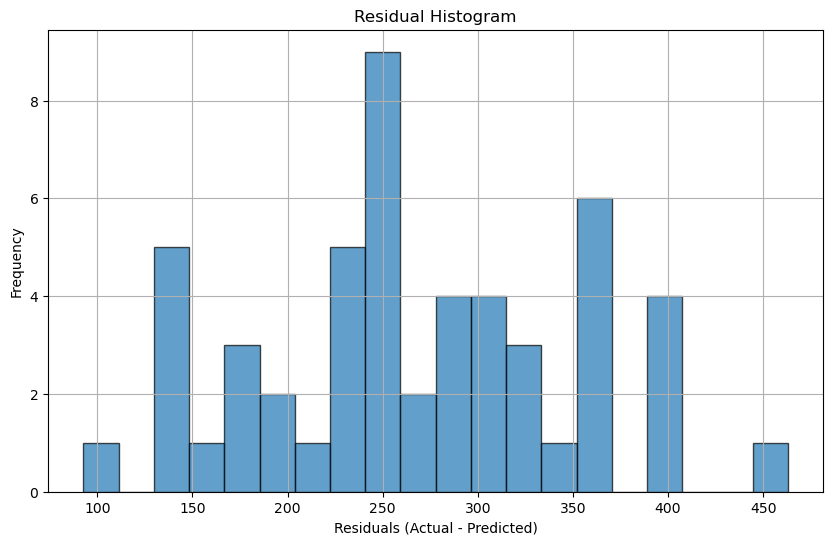

In [82]:
residuals = actual_values - predicted_values
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
plt.title('Residual Histogram')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

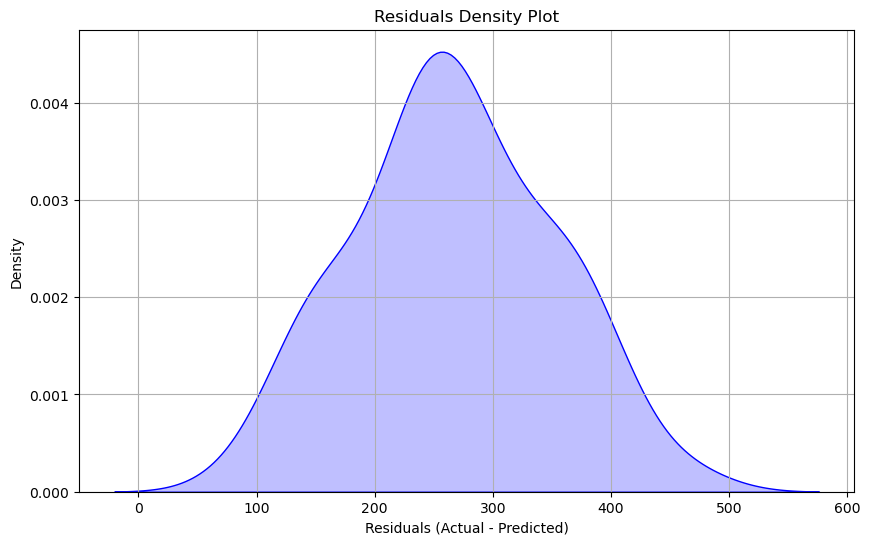

In [83]:
plt.figure(figsize=(10, 6))
sns.kdeplot(residuals, fill=True, color='b')
plt.title('Residuals Density Plot')
plt.xlabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()

The residuals are very high, centered around 250. the MSE, MAE,and MAPE are also very high, almost as high as in the first model.

#### 5.2.2 Autopilot

In [69]:
url_data = "s3://c125236a3097401l7846476t1w2750781236-sandboxbucket-zceqpzjq7ylu/rent_crime_yearly.csv"
rent_crime_yearly = pd.read_csv(url_data)
rent_crime_yearly = rent_crime_yearly.drop(columns = ['Location'])

In [70]:
rent_crime_yearly_grouped = rent_crime_yearly.groupby('Location Id')
rent_crime_yearly['Crime_Rolling_Std_3'] = rent_crime_yearly_grouped['Crime'].apply(lambda x: x.rolling(3,1).std()).reset_index(level=0, drop=True)
rent_crime_yearly['Crime_Rolling_Std_6'] = rent_crime_yearly_grouped['Crime'].apply(lambda x: x.rolling(6,1).std()).reset_index(level=0, drop=True)
rent_crime_yearly.dropna(inplace=True)

In [71]:
rent_crime_yearly['Year'] = pd.to_datetime(rent_crime_yearly['Year'], format='%Y') + pd.offsets.DateOffset(months=0, days=0)
rent_crime_yearly.set_index('Year', inplace=True)

In [72]:
rent_crime_yearly = rent_crime_yearly[['Median Rent','Location Id','Crime_Rolling_Std_3','Crime_Rolling_Std_6']]

In [73]:
rent_crime_yearly_train = rent_crime_yearly[rent_crime_yearly.index < dt.datetime(year=2018, month=1, day=1)].copy()
rent_crime_yearly_validation = rent_crime_yearly[(rent_crime_yearly.index >= dt.datetime(year=2018, month=1, day=1)) & (rent_crime_yearly.index < dt.datetime(year=2021, month=1, day=1))].copy()
rent_crime_yearly_test = rent_crime_yearly[rent_crime_yearly.index >= dt.datetime(year=2021, month=1, day=1)].copy()

Since the amount of training data for autopilot must be greater than 500, I doubled the training set.

In [74]:
rent_crime_yearly_train = pd.concat([rent_crime_yearly_train, rent_crime_yearly_train], axis=0)

In [76]:
bucket='c125236a3097401l7846476t1w2750781236-sandboxbucket-zceqpzjq7ylu'
prefix='hyperparam'
train_file='rent_crime_yearly_train.csv'
test_file='rent_crime_yearly_test.csv'
validate_file='rent_crime_yearly_validation.csv'
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=True, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

upload_s3_csv(train_file, 'train', rent_crime_yearly_train)
upload_s3_csv(test_file, 'test', rent_crime_yearly_test)
upload_s3_csv(validate_file, 'validate', rent_crime_yearly_validation)

In [77]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
train_data_uri = f's3://{bucket}/{prefix}/train/rent_crime_yearly_train.csv'
output_uri = f's3://{bucket}/{prefix}/output/'
job_name = 'rent-crime-yearly-autopilot-job'
max_candidates = 100 

In [78]:
automl_job = AutoML(
    role=role,
    target_attribute_name='Median Rent',  
    output_path=output_uri,
    problem_type='Regression', 
    job_objective={'MetricName': 'MSE'},  
    max_candidates=max_candidates,
    sagemaker_session=sagemaker_session
)


automl_job.fit(
    inputs=train_data_uri,
    wait=True,
    logs='All',
    job_name=job_name
)

...................................................................................................................................................................................................................................................
..

In [79]:
sagemaker_session = sagemaker.Session()
best_candidate = automl_job.describe_auto_ml_job()['BestCandidate']
best_candidate_name = best_candidate['CandidateName']
print("Best Candidate Name: ", best_candidate_name)

Best Candidate Name:  rent-crime-yearly-autopilot-jo6s-027-b85a6664


In [80]:
algo_estimator = Estimator.attach(best_candidate_name)
best_algo_model = algo_estimator.create_model(env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"})


2024-10-09 00:59:20 Starting - Found matching resource for reuse
2024-10-09 00:59:20 Downloading - Downloading the training image
2024-10-09 00:59:20 Training - Training image download completed. Training in progress.
2024-10-09 00:59:20 Uploading - Uploading generated training model
2024-10-09 00:59:20 Completed - Resource reused by training job: rent-crime-yearly-autopilot-jo6s-035-cb2cc501


In [81]:
predictor = best_algo_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

------!

In [82]:
s3_client = boto3.client('s3')
bucket_name='c125236a3097401l7846476t1w2750781236-sandboxbucket-zceqpzjq7ylu'
file_key = 'hyperparam/test/rent_crime_yearly_test.csv' 

response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
test_data = pd.read_csv(response['Body'])

features = test_data.drop(columns=['Median Rent'])
actual_values = test_data['Median Rent']

In [83]:
csv_buffer = io.StringIO()
features.to_csv(csv_buffer, header=False, index=False)

csv_bytes = csv_buffer.getvalue().encode('utf-8')
predictions = predictor.predict(csv_bytes, initial_args={"ContentType": "text/csv"})

In [84]:
predicted_values = pd.read_csv(io.StringIO(predictions.decode('utf-8')), header=None).values.flatten()

In [85]:
mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
metrics_df = pd.DataFrame({
    'MSE': [mse],
    'MAE': [mae],
    'MAPE': [mape]
})
metrics_df

,MSE,MAE,MAPE
0,52677.665306,215.215647,0.407449


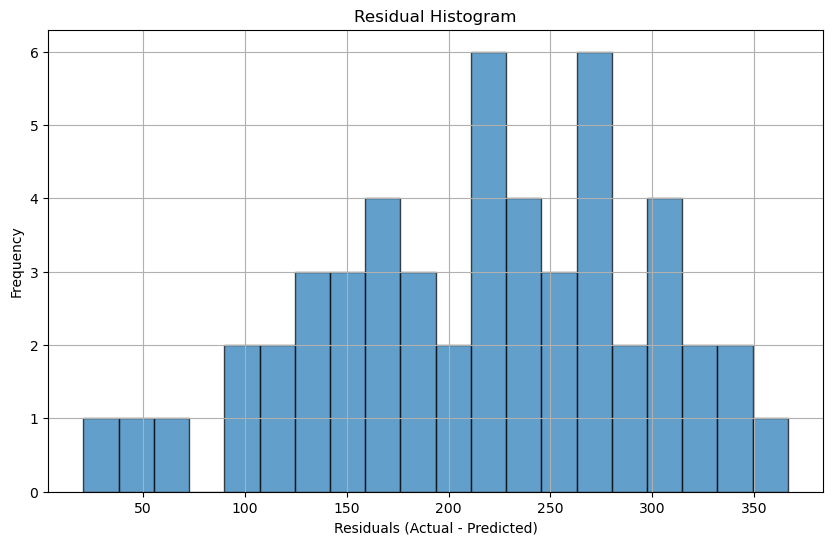

In [86]:
residuals = actual_values - predicted_values
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, edgecolor='k', alpha=0.7)
plt.title('Residual Histogram')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

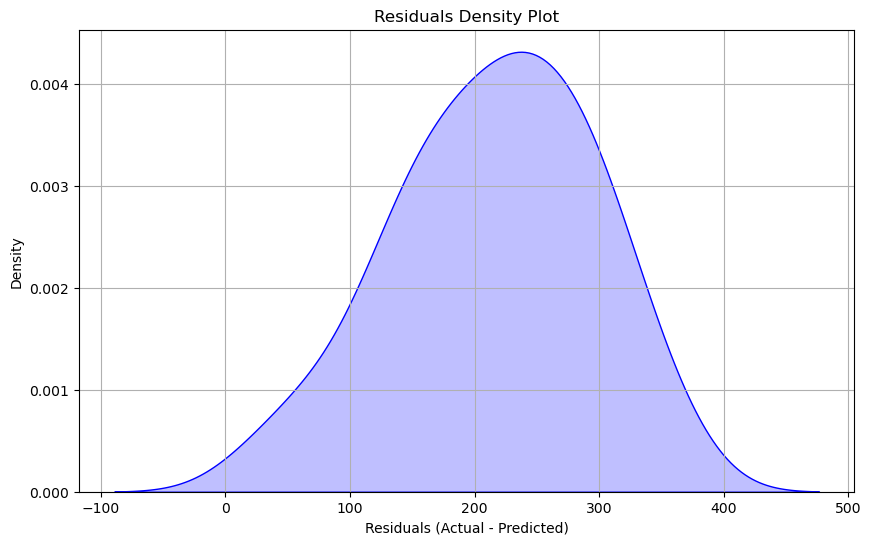

In [87]:
plt.figure(figsize=(10, 6))
sns.kdeplot(residuals, fill=True, color='b')
plt.title('Residuals Density Plot')
plt.xlabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()

This model is slightly better than the previous one. However, most of the residuals are still large.

### 5.3 Best Crime and Rent Model

Both monthly and yearly crime data failed to train well-performing models due to poor correlation. The best of these models are shown below. I have downloaded it locally from S3.

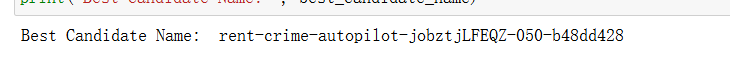

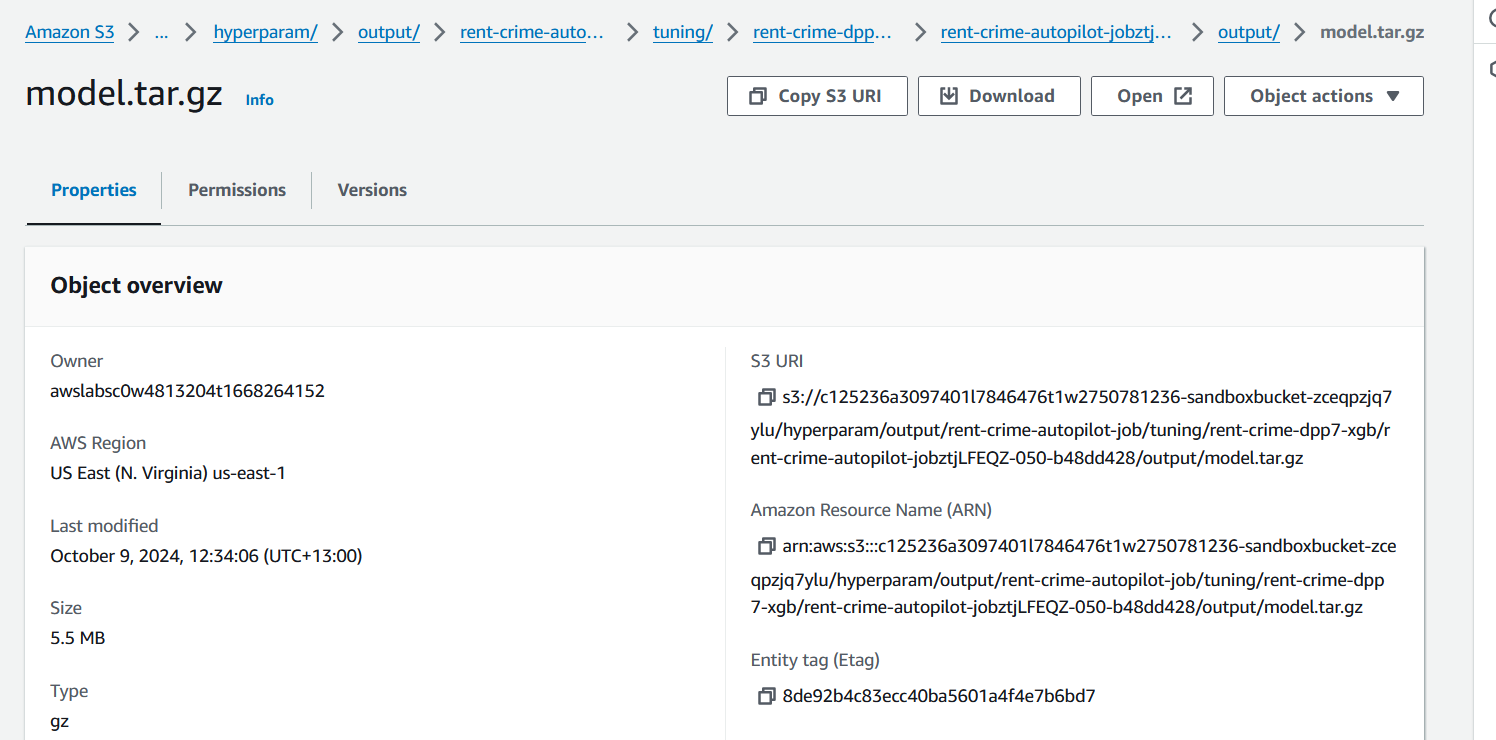

## 6.Web Application

Using Streamlit for Web Applications. The following URL leads to this Streamlit app: https://159301-iexjeepp2org8mtgpwczcz.streamlit.app/

### 6.1 Predict All

Use ARIMA to forecast rents separately for all regions for the selected dates. The results are displayed on a map

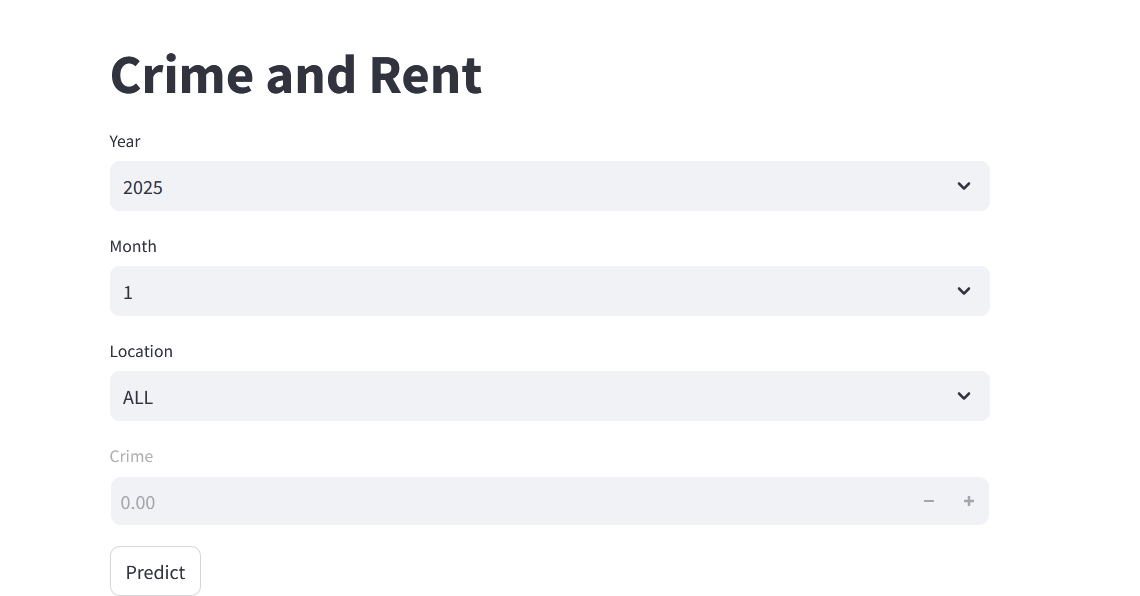

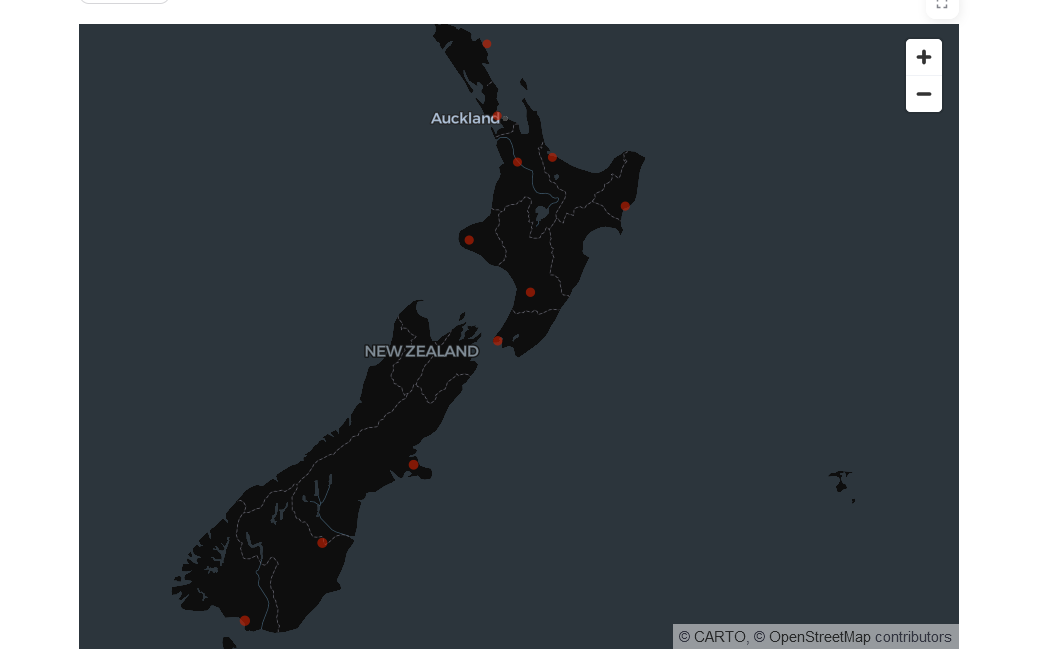

### 6.2 Prediction of selected regions

Predictions for selected regions are made using the previous model and the crime data predicted earlier. Users can also use their own input crime data to make predictions.The results are displayed on a map.

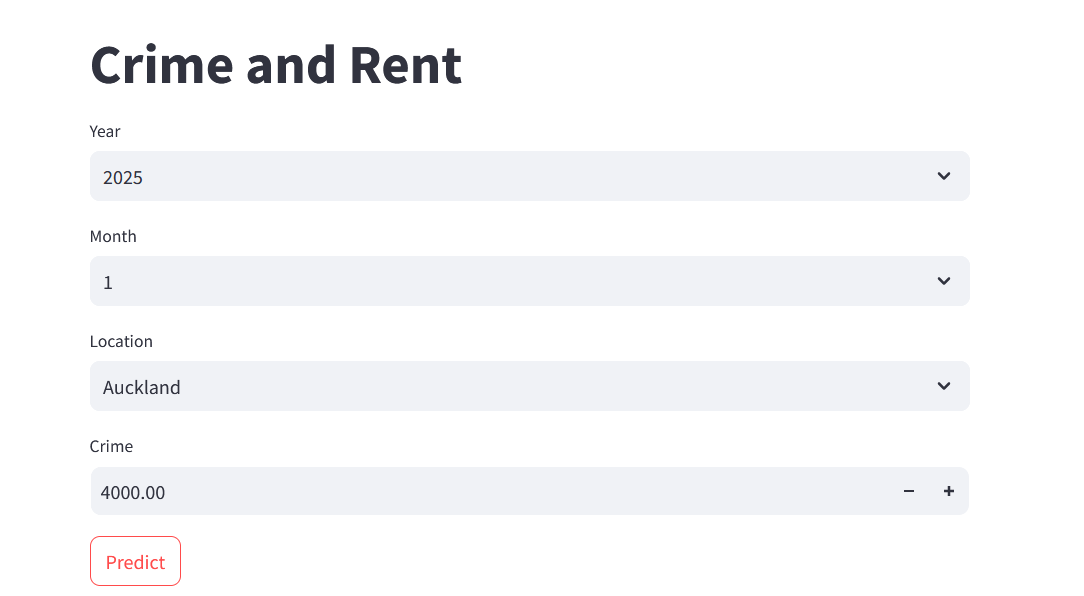

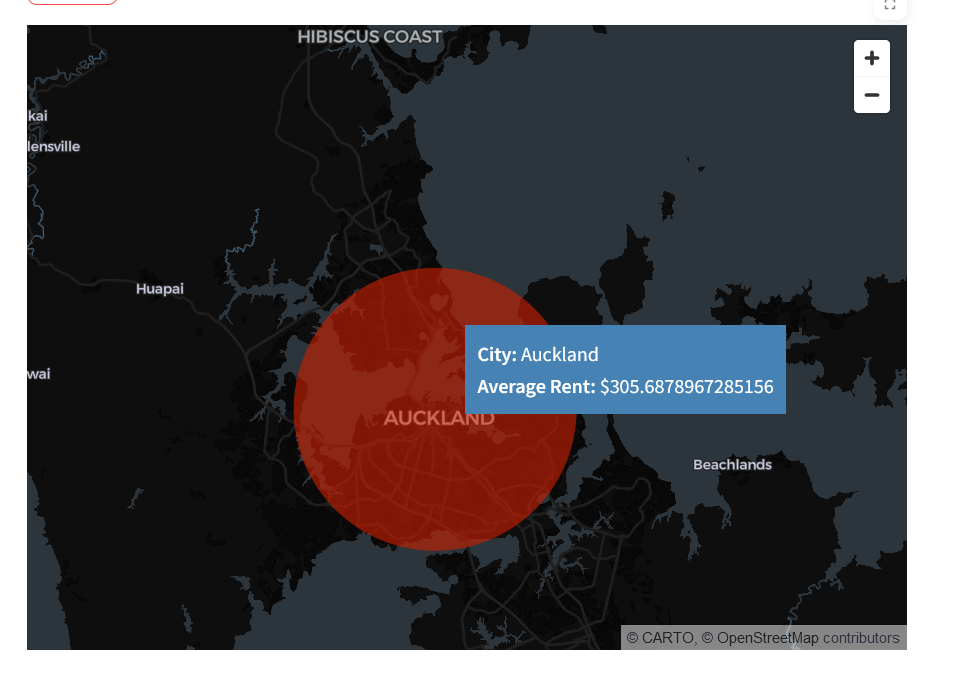